# Clustering clinical Data

We want to provide some way of easy input for the users so we need to abstract the 125+ features into some groups that are semantically related and could be described in a way their data is made of, for each group

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sys, os
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from scipy.stats import kruskal

from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


#plt.style.use("seaborn-paper")
sns.set_context("paper")

# omit annoying futurewarnings in tsne
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.abspath('src/'))
from data.lungdataset import LungData

plt.style.use('seaborn-paper')
plt.rcParams.update({"axes.facecolor" : "white",
                     "axes.edgecolor":  "black",
                     "patch.facecolor": "white",
                     "figure.facecolor" : "white"}) # prevent the transparency WHEREEVER IT CAME FROM?!
sns.set_context("paper", font_scale=1.6, rc={"lines.linewidth": 2.5, "lines.markersize" : 7.5})

In [2]:
rootdir = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh1_A"
ld = LungData(rootdir)
medical_df = ld.raw_ehd
image_df = ld.as_dataframe()
#ld.as_dataframe()

In [3]:
df = ld.process_features(return_df=True, normalize_dates=False)

targets = ["last.status", "is_icu", "was_ventilated"]
df_targets = df[targets]

X = df.drop(targets, axis=1)
print("Dataset shape: ", X.shape)


Dataset shape:  (1279, 74)


In [4]:
X.head()

kidney_replacement_therapy  kidney_transplant  htn_v  dm_v  cad_v  ckd_v  \
0                         0.0                0.0    0.6   0.4    0.6    0.4   
1                         0.0                0.0    0.6   0.0    0.0    0.0   
2                         0.0                0.0    1.0   0.0    1.0    0.0   
3                         0.0                0.0    1.0   1.0    1.0    1.0   
4                         0.0                0.0    0.0   0.0    0.0    0.0   

   malignancies_v  copd_v  other_lung_disease_v  acei_v  ...  \
0             0.2     0.0          2.000000e-01     0.0  ...   
1             0.2     0.0         -2.775558e-17     0.2  ...   
2             0.0     1.0          1.000000e+00     0.0  ...   
3             0.0     1.0          0.000000e+00     0.0  ...   
4             0.0     0.0          0.000000e+00     0.0  ...   

   Urine.protein_Normal  Urine.protein_nan  hf_ef_v_HFpEF  hf_ef_v_HFrEF  \
0                   1.0                0.0            0.0            0.0   
1                   0.0                0.0            0.0            0.0   
2                   0.0                0.0            0.0            0.0   
3                   0.0                0.0            0.0            1.0   
4                   0.0                1.0            1.0            0.0   

   hf_ef_v_No  hf_ef_v_nan  smoking_status_v_Current  smoking_status_v_Former  \
0         0.0          1.0                       0.0                      0.0   
1         0.0          1.0                       0.0                      0.0   
2         1.0          0.0                       0.0                      0.0   
3         0.0          0.0                       0.0                      1.0   
4         0.0          0.0                       0.0                      0.0   

   smoking_status_v_Never  smoking_status_v_nan  
0                     0.0                   1.0  
1                     0.0                   1.0  
2                     1.0                   0.0  
3                     0.0                   0.0  
4                     1.0                   0.0  

[5 rows x 74 columns]

<AxesSubplot:>

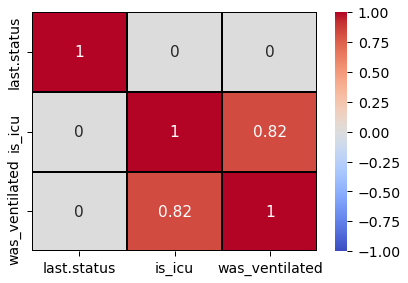

In [5]:
corr_df = df.corr()[targets]
sns.heatmap(corr_df[corr_df.abs()>0.5].dropna(thresh=1).round(3).fillna(0),
 vmin=-1, vmax=1, cmap="coolwarm", linecolor="black", linewidths=2, annot=True)

In [6]:
thresh = 0.9
corr_df = df.corr()
#sns.heatmap(corr_df[corr_df.abs()>0.9].dropna(thresh=1).round(3).fillna(0),
# vmin=-1, vmax=1, cmap="coolwarm")
corr_df[corr_df.abs()>thresh].dropna(thresh=1).round(3).fillna("-")

last.status is_icu was_ventilated  \
last.status                        1.0      -              -   
is_icu                               -    1.0              -   
was_ventilated                       -      -            1.0   
kidney_replacement_therapy           -      -              -   
kidney_transplant                    -      -              -   
...                                ...    ...            ...   
hf_ef_v_nan                          -      -              -   
smoking_status_v_Current             -      -              -   
smoking_status_v_Former              -      -              -   
smoking_status_v_Never               -      -              -   
smoking_status_v_nan                 -      -              -   

                           kidney_replacement_therapy kidney_transplant htn_v  \
last.status                                         -                 -     -   
is_icu                                              -                 -     -   
was_ventilated                                      -                 -     -   
kidney_replacement_therapy                        1.0                 -     -   
kidney_transplant                                   -               1.0     -   
...                                               ...               ...   ...   
hf_ef_v_nan                                         -                 -     -   
smoking_status_v_Current                            -                 -     -   
smoking_status_v_Former                             -                 -     -   
smoking_status_v_Never                              -                 -     -   
smoking_status_v_nan                                -                 -     -   

                           dm_v cad_v ckd_v malignancies_v  ...  \
last.status                   -     -     -              -  ...   
is_icu                        -     -     -              -  ...   
was_ventilated                -     -     -              -  ...   
kidney_replacement_therapy    -     -     -              -  ...   
kidney_transplant             -     -     -              -  ...   
...                         ...   ...   ...            ...  ...   
hf_ef_v_nan                   -     -     -              -  ...   
smoking_status_v_Current      -     -     -              -  ...   
smoking_status_v_Former       -     -     -              -  ...   
smoking_status_v_Never        -     -     -              -  ...   
smoking_status_v_nan          -     -     -              -  ...   

                           Urine.protein_Normal Urine.protein_nan  \
last.status                                   -                 -   
is_icu                                        -                 -   
was_ventilated                                -                 -   
kidney_replacement_therapy                    -                 -   
kidney_transplant                             -                 -   
...                                         ...               ...   
hf_ef_v_nan                                   -                 -   
smoking_status_v_Current                      -                 -   
smoking_status_v_Former                       -                 -   
smoking_status_v_Never                        -                 -   
smoking_status_v_nan                          -                 -   

                           hf_ef_v_HFpEF hf_ef_v_HFrEF hf_ef_v_No hf_ef_v_nan  \
last.status                            -             -          -           -   
is_icu                                 -             -          -           -   
was_ventilated                         -             -          -           -   
kidney_replacement_therapy             -             -          -           -   
kidney_transplant                      -             -          -           -   
...                                  ...           ...        ...         ...   
hf_ef_v_nan                            -             -          -         1.0   
smo

## 1. K-Means

In [7]:
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def compare_kmeans(X, scaled=True):
    _sc = "unscaled"
    if scaled:
        scaler = StandardScaler()
        x = scaler.fit_transform(X).copy()
        _sc = "scaled"
    else:
        x = X.copy()

    res = pd.DataFrame()

    n = 100
    K = range(1,25)

    for i in range(n):
        distortions = []
        for k in K:
            kmeansModel = KMeans(init="random", n_clusters=k)
            kmeansModel.fit(x)
            #distortions.append(sum(np.min(cdist(X_scaled, kmeansModel.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])
            distortions.append(kmeansModel.inertia_)
        res[i] = distortions

    means = list(res.mean(axis=1))
    ci_hi = list(res.mean(axis=1) + 1*res.std(axis=1))
    ci_lo = list(res.mean(axis=1) - 1*res.std(axis=1))
    ci95_hi = list(res.mean(axis=1) + 1.96*res.std(axis=1)/math.sqrt(n))
    ci95_lo = list(res.mean(axis=1) - 1.96*res.std(axis=1)/math.sqrt(n))

    distortions = []
    for k in K:
        kmeansModel = KMeans(init="k-means++", n_clusters=k)
        kmeansModel.fit(x)
        #distortions.append(sum(np.min(cdist(X_scaled, kmeansModel.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])
        distortions.append(kmeansModel.inertia_)
    fig = plt.figure(figsize=(12,5))
    plt.plot(K, means, 'o--', label="random")
    plt.fill_between(K, ci_lo, ci_hi, alpha=0.35, label='error band')
    plt.plot(K, distortions, 'go--', label="k-means++")
    #plt.vlines(6, 9, 12, linestyles="dotted", colors="gray")
    #if scaled:
    #    plt.vlines(6, 38000, 62000, linestyles="dotted", colors="gray")
    #else:
    #    plt.vlines(6, 0, 2*1e10, linestyles="dotted", colors="gray")
    plt.xlabel('k')
    plt.ylabel('Distortion')
    #plt.title(f'The elbow method showing the optimal k - comparing random and k-means++ over {n} repetitions with {_sc} Data')
    plt.legend()
    #plt.show()
    return plt


In [8]:
#p = compare_kmeans(X)
#p.savefig("../thesis/figures/impl/clustering/kmeans.png", dpi=320)
#compare_kmeans(X, scaled=False)

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
pipe = Pipeline([('scaler', StandardScaler())])

def clustering_scores(scorer, scorer_name, X):
    c=[0,1]
    r=[0,1]
    alg=["ward", "kmeans"]
    _sc=[False, True]

    fig, ax = plt.subplots(2,2, figsize=(15,6), sharex=True)

    for i, sc in zip(c, _sc):
        for j, model in zip(r,alg):
            scores=[]
            if sc:
                x = pipe.fit_transform(X)
            else:
                x = X
            for n in range(2,15):
                if model == "ward":
                    clustering = AgglomerativeClustering(linkage="ward", n_clusters=n).fit(x)
                    scores.append(scorer(x, clustering.labels_))
                elif model == "kmeans":
                    clustering = KMeans(init="k-means++", n_clusters=n).fit(x)
                    scores.append(scorer(x, clustering.predict(x)))
    #        print(i,j,a, sc)
            #sns.lineplot(data=scores, markers=True, ax=ax[i][j])
            plt.sca(ax[i][j])
            plt.plot(range(0,13), scores, "bo--")
            if scorer_name=="Silhouette Scores":
                if i==0:
                    ax[i][j].set_yticks([x/10 for x in range(3,10,1)])
                elif i==1:
                    ax[i][j].set_yticks([x/1000 for x in range(25,200,25)])
            ax[i][j].set_xticks(range(0,13), labels=range(2,15))
            ax[i][j].set_title(f"{model} scaling: {sc}")
    fig.suptitle(f"{scorer_name}")
    fig.tight_layout()


In [10]:
#clustering_scores(metrics.silhouette_score, "Silhouette Scores", X)
#clustering_scores(metrics.calinski_harabasz_score, "Calinski-Harabasz Index", X)

__Silhoutte__: Best value 1, 0 means overlapping clusters, -1 is bad. On unscaled data it drops after 5. on Scaled data it drops before but not as critical. 

__Calinski__: Best value would be a peak, for smooth lines (increase/decrease) we cannot potentially say one would be better. For scaled it drops with more k, for unscaled complete opp. 

---
Set some defaults for reproducible runs 


5.0  6.5  8.0  9.5  11.0 12.5 14.0 15.5 17.0 18.5 20.0 21.5 23.0 24.5
5     3    3    2    5    2    2    2    2    2    2    2    2    2    2
10    2    2    2    2    2    2    2    2    2    2    2    2    2    2
15    2    2    2    2    2    2    2    2    2    2    2    2    2    2
20    2    2    2    2    2    2    2    2    2    2    2    2    2    2
25    2    2    2    2    2    2    2    2    2    2    2    2    2    2

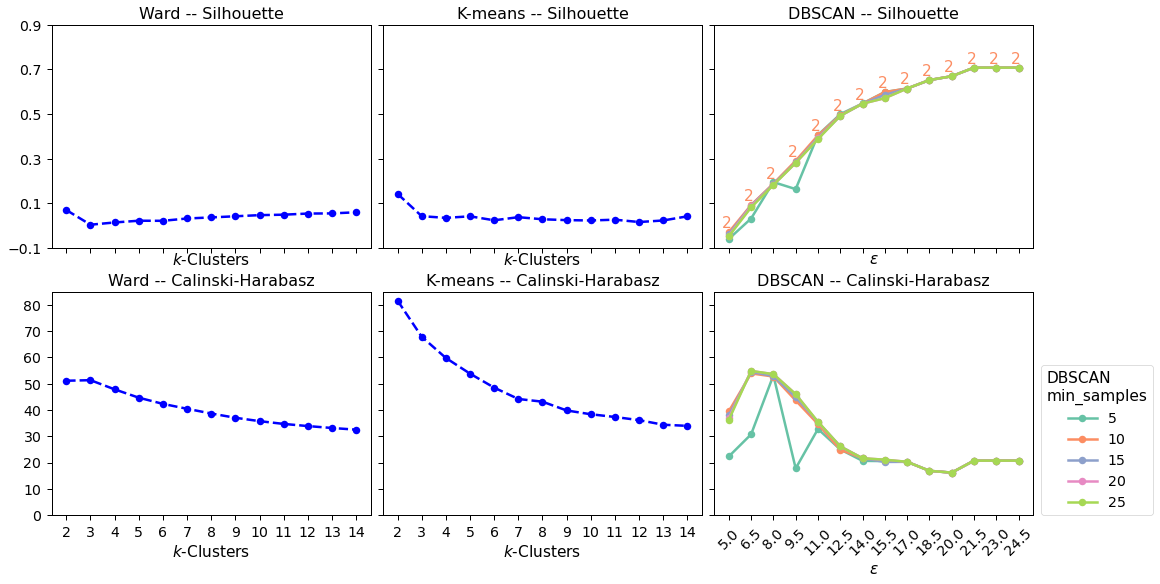

In [11]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from matplotlib import cm

pipe = Pipeline([('scaler', StandardScaler())])


alg=["Ward", "K-means", "DBSCAN"]

fig, ax = plt.subplots(2, 3, figsize=(16,8), sharex="col", sharey="row",
                        constrained_layout=True,
                        #gridspec_kw=dict(left=0., right=1.,
                        #                 bottom=0.5, top=0.6)
                        )
x = pipe.fit_transform(X)

scorers = [metrics.silhouette_score, metrics.calinski_harabasz_score]

for j, model in enumerate(alg):
    for i, scorer in enumerate(scorers): 
        scores=[]
        if model != "DBSCAN":
            for n in range(2,15):
                if model == "Ward":
                    clustering = AgglomerativeClustering(linkage="ward", n_clusters=n).fit(x)
                    scores.append(scorer(x, clustering.labels_))
                elif model == "K-means":
                    clustering = KMeans(init="k-means++", n_clusters=n).fit(x)
                    scores.append(scorer(x, clustering.predict(x)))
        elif model == "DBSCAN":
            #steps =  [1, 1.5, 2, 5, 10, 15, 20, 25, 35, 40, 50]
            steps = [x/10 for x in range(50,250,15)]
            n_clus = pd.DataFrame(columns=steps)
            neighbors = [5, 10, 15, 20, 25]
            #steps = np.array(sorted(np.random.uniform(5,25, 13))).round(2)
            for c, neighbor in enumerate(neighbors):
                for eps in steps:
                    clustering = DBSCAN(eps=eps, min_samples=neighbor).fit(x)
                    #print(pd.DataFrame(clustering.labels_).value_counts())
                    scores.append(scorer(x, clustering.labels_))
                    n_clus.at[neighbor, eps] = len(set(clustering.labels_))
                    if neighbor==10 and i == 0:
                        ax[i,j].text(eps-0.5, scorer(x, clustering.labels_)+0.02, len(set(clustering.labels_)), color=cm.Set2(1))
                ax[i,j].plot(steps, scores, "o-", label=f"{neighbor}", color=cm.Set2(c))
                
                scores = []
        #print(i,j,a, sc)
        #sns.lineplot(data=scores, markers=True, ax=ax[i][j])
        plt.sca(ax[i][j])
        if model != "DBSCAN":
            plt.plot(range(0,13), scores, "bo--")
            ax[i][j].set_xticks(range(0,13), labels=range(2,15))
            ax[i][j].set_xlabel(r"$k$-Clusters")
        else:
            ax[i][j].set_xticks(steps, labels=steps, rotation=45)
            ax[i][j].set_xlabel(r"$\epsilon$")
            if i == 1:
                ax[i][j].legend(loc=(1.025,0.), title="DBSCAN\nmin_samples")
        if i == 0:
            ax[i][j].set_title(f"{model} -- Silhouette", size=16)
            #ax[i][j].set_yticks([x/1000 for x in range(-25,150,25)])
            ax[i][j].set_yticks([x/100 for x in range(-10, 100, 20)])
        elif i == 1:
            ax[i][j].set_title(f"{model} -- Calinski-Harabasz", size=16)
            ax[i][j].set_yticks(range(0,90,10))

n_clus
fig.savefig("../thesis/figures/impl/clustering/comparison_dbscan_.png")
#fig.tight_layout()

In [12]:
n_clus

5.0  6.5  8.0  9.5  11.0 12.5 14.0 15.5 17.0 18.5 20.0 21.5 23.0 24.5
5     3    3    2    5    2    2    2    2    2    2    2    2    2    2
10    2    2    2    2    2    2    2    2    2    2    2    2    2    2
15    2    2    2    2    2    2    2    2    2    2    2    2    2    2
20    2    2    2    2    2    2    2    2    2    2    2    2    2    2
25    2    2    2    2    2    2    2    2    2    2    2    2    2    2

In [13]:
seed = 42
n_clusters = 3

## 2. PCA

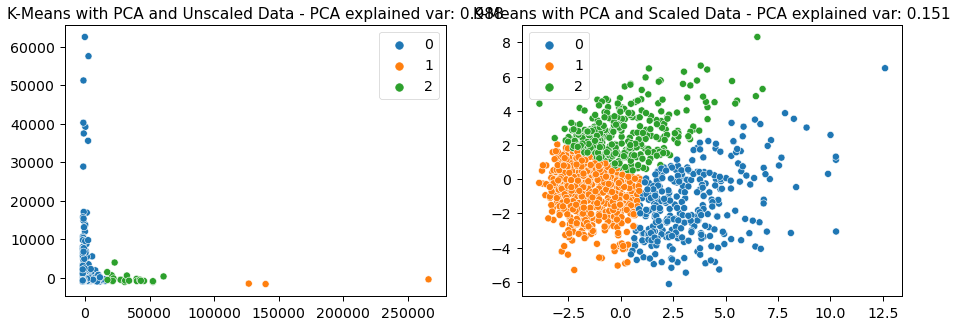

In [14]:
from sklearn.decomposition import PCA

#n_clusters = 6
pipe = Pipeline([('pca', PCA(n_components=2, random_state=seed)),])
pipe_s = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=2, random_state=seed)),
                 ])
pipelines=[pipe, pipe_s]
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i,p in enumerate(pipelines):
    Xs = p.fit_transform(X)
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, random_state=seed).fit(Xs)
    c = kmeans.predict(Xs)
    expl_var = sum(p["pca"].explained_variance_ratio_[:2])
    #print("Explained variance by 2 principal components: {:.3f}".format(sum(p["pca"].explained_variance_ratio_[:2])))
    sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], s=50,
                hue=c, palette=sns.color_palette()[:n_clusters],
                ax=ax[i])
    if i == 0: ax[i].set_title("K-Means with PCA and Unscaled Data - PCA explained var: {:.3f}".format(expl_var))
    else: ax[i].set_title("K-Means with PCA and Scaled Data - PCA explained var: {:.3f}".format(expl_var))


---
### How many components?

0.95% variance

In [15]:
_n = X.shape[1]

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(random_state=seed, n_components=_n)),
                 ])
Xs = pipe.fit_transform(X)
_pca = pipe.named_steps["pca"]
n_comp = _pca.n_components_
print(f"{_pca.n_components} variance: {n_comp} from {X.shape[1]}")

# https://hosted.jalt.org/test/PDF/Brown30.pdf 
# Kaisers stopping rule -> variance greater 1

print("Kaisers stopping: {}".format(sum(_pca.explained_variance_ > 1)))


74 variance: 74 from 74
Kaisers stopping: 26


In [16]:
np.cumsum(_pca.explained_variance_ratio_[:-19])
len(_pca.explained_variance_ratio_[:-19])

55

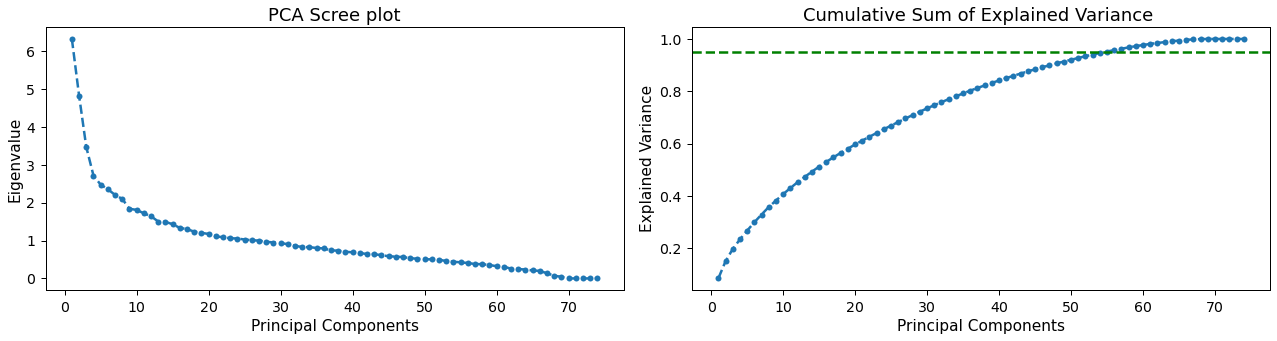

In [17]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(random_state=seed, n_components=n_comp)),
                 ])

Xs = pipe.fit_transform(X)
_pca = pipe.named_steps["pca"]

fig, ax = plt.subplots(1,2, figsize=(18,5))

pcs = range(1, _pca.n_components_+1)

ax[0].plot(pcs, _pca.explained_variance_, '--', marker="o", markersize=6)
ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel('Eigenvalue')
ax[0].set_title("PCA Scree plot", size=18)

ax[1].plot(pcs, np.cumsum(_pca.explained_variance_ratio_), '--', marker="o", markersize=6)
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Explained Variance')
ax[1].set_title("Cumulative Sum of Explained Variance ", size=18)
l1 = ax[1].axhline(0.95, color="g", ls="--")

fig.tight_layout()
fig.savefig("../thesis/figures/impl/clustering/pca_decisions.png", dpi=320)

#ax[1].set_xticks(pcs)

From above we can make up: 

- The cumulative score of explained variances to hit 95% of the variance takes __55__ PCs
- Kaisers stopping would only take PCs whos eigenvalues are higher than 1, which would lead us to __26__ PCs
- A scree plot shows that there is a massive drop in explainability after the 4th-6th PC, so it would assume something between 4-6 __PCs__

Let's test all shall we...
    

In [18]:
_pcs = [55, 26, 4, 3, 2]
res_pca = pd.DataFrame()

for n_component in _pcs:

    pipe = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(random_state=seed, n_components=n_component)),
                    ])

    Xs = pipe.fit_transform(X)
    _pca = pipe.named_steps["pca"]

    alg = ["Ward", "K-means"]

    #fig, ax = plt.subplots(2, 2, figsize=(18,8))

    for i, model in enumerate(alg):
        k = range(2,16)
        scores_sil = []
        scores_cal = []
        for _k in k:
            if model == "Ward":
                clustering = AgglomerativeClustering(linkage="ward", n_clusters=_k).fit(Xs)
                scores_sil.append(metrics.silhouette_score(Xs, clustering.labels_))
                scores_cal.append(metrics.calinski_harabasz_score(Xs, clustering.labels_))
            elif model == "K-means":
                clustering = KMeans(init="k-means++", n_clusters=_k, random_state=seed).fit(Xs)
                scores_sil.append(metrics.silhouette_score(Xs, clustering.predict(Xs)))
                scores_cal.append(metrics.calinski_harabasz_score(Xs, clustering.predict(Xs)))
        for s, m in zip([scores_sil, scores_cal], ["Silhouette", "Calinski-Harabasz"]):
            r = {"model" : model, "score" : s, "metric" : m,
                "k" : k, "pc" : n_component}
            res_pca = res_pca.append(pd.DataFrame(r))
        # plot sil
        #ax[0,i].plot(k, scores_sil, "bo--")
        #ax[0,i].set_title(f"{model} - Silhouette Scores", size=18)
        # plot cal
        #ax[1,i].plot(k, scores_cal, "bo--")
        #ax[1,i].set_title(f"{model} - Calinski-Harabasz Scores", size=18)

    #fig.suptitle(f"Choosing right K - {n_component} PCs", size=22)
    #fig.tight_layout()
    #fig.savefig(f"images/figures/pca/{n_component}.png")

In [19]:
res_dbscan = pd.DataFrame()

babysteps=[0.1, 0.25, 0.5, 0.75, 1] 
steps = [x/100 for x in range(200,2500,150)]
steps = babysteps + steps
n_clus = pd.DataFrame(columns=steps)
neighbors = [5, 10, 15, 20, 25]

for n_component in _pcs:
    print(n_component)
    pipe = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(random_state=seed, n_components=n_component)),
                    ])
    Xs = pipe.fit_transform(X)
    _pca = pipe.named_steps["pca"]
    for eps in steps:
        for min_samples in neighbors:
            scores_sil = []
            scores_cal = []
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(Xs)
            #print(eps, min_samples, len(set(clustering.labels_)))
            try:
                scores_sil.append(metrics.silhouette_score(Xs, clustering.labels_))
                scores_cal.append(metrics.calinski_harabasz_score(Xs, clustering.labels_))
            except ValueError:
                scores_sil.append(np.nan)
                scores_cal.append(np.nan)
            for s, m in zip([scores_sil, scores_cal], ["Silhouette", "Calinski-Harabasz"]):
                r = {"model" : "DBSCAN", "score" : s, "metric" : m, "min_samples" : min_samples,
                    "eps" : eps, "pc" : n_component, "n_clusters" : len(set(clustering.labels_))}
                #print(r)
                res_dbscan = res_dbscan.append(pd.DataFrame(r))


55
26
4
3
2


In [20]:
res_dbscan.query("metric == 'Silhouette' and n_clusters != 2").sort_values(by="score", ascending=False)[:25].head(3)

model     score      metric  min_samples   eps  pc  n_clusters
0  DBSCAN  0.360842  Silhouette            5  0.75   2           3
0  DBSCAN  0.307089  Silhouette           15  1.00   3           3
0  DBSCAN  0.299163  Silhouette           20  1.00   3           3

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be 

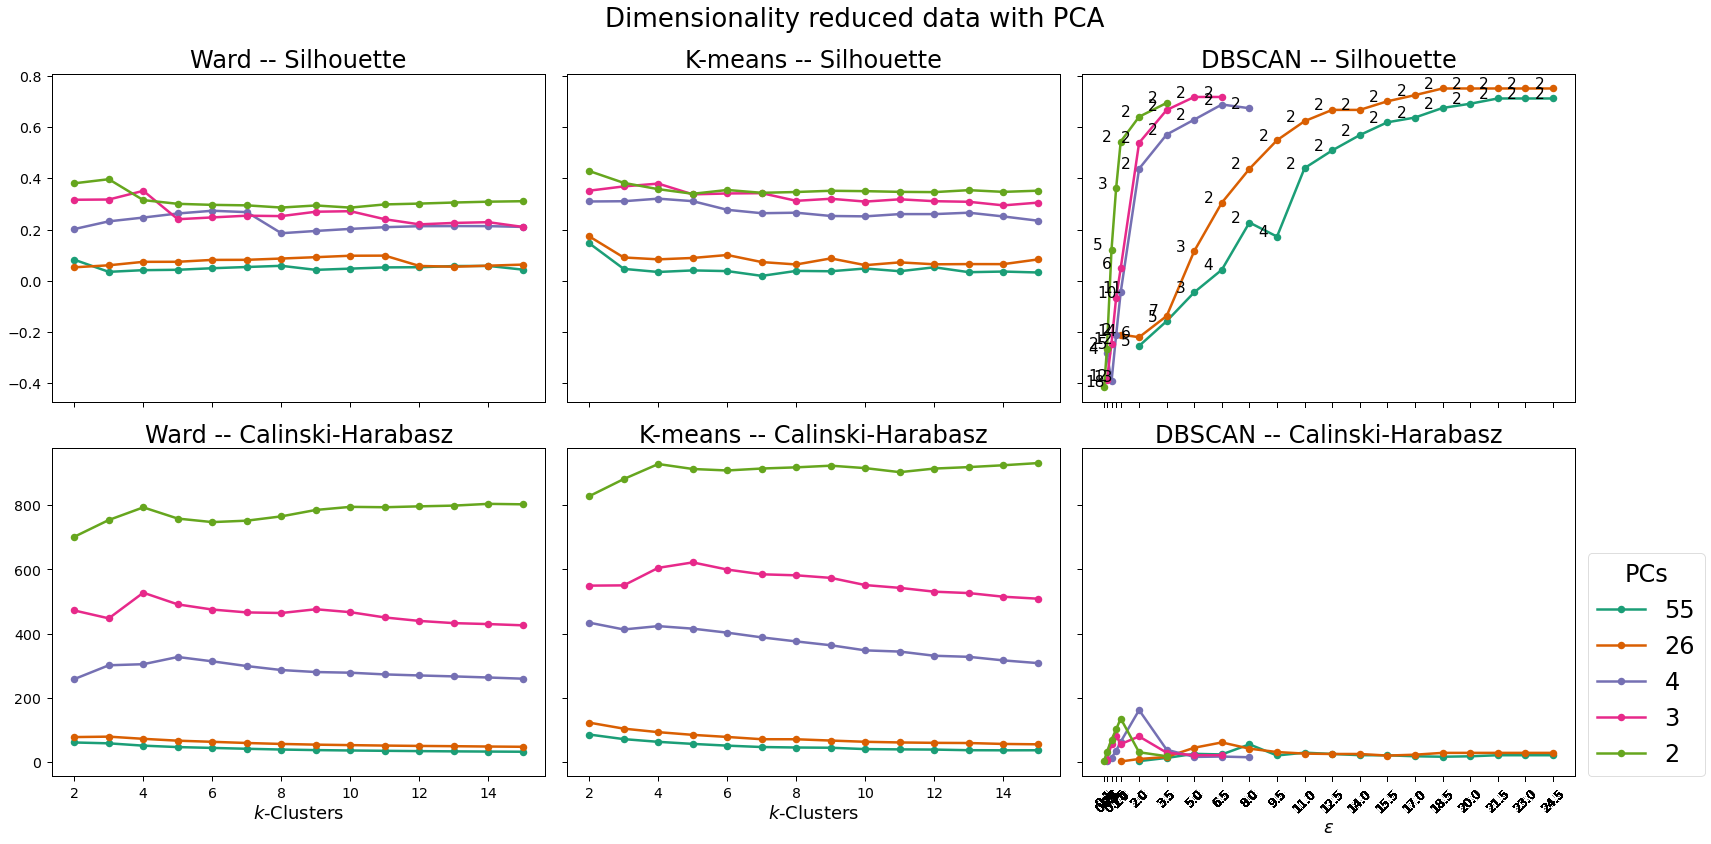

In [21]:
import matplotlib as mpl
from matplotlib import cm

fig,ax = plt.subplots(2,3, figsize=(24,12), sharey="row", sharex="col", 
    constrained_layout=True
    )

_models = ["Ward", "K-means", "DBSCAN"]
_metrics = ["Silhouette", "Calinski-Harabasz"]
for i, mod in enumerate(_models):
    if mod != "DBSCAN":
        for j, met in enumerate(_metrics):
            _qdf = res_pca.query("model == @mod and metric == @met")
            for c, p in enumerate(_qdf["pc"].unique()):
                _qqdf = _qdf[_qdf["pc"] == p]
                ax[j,i].plot(_qqdf["k"], _qqdf["score"], "o-", label=f"{p}", color=cm.Dark2(c))
            ax[j,i].set_title(f"{mod} -- {met}", size=24)
            if j == 1:
                ax[j,i].set_xlabel(r"$k$-Clusters", size=18)
            # if j==1 and i == 1:
            #     ax[j,i].legend(loc=(1.025,0.), title="PCs",
            #         #ncol=len(_qdf["pc"].unique())
            #         )
    elif mod == "DBSCAN":
        for j, met in enumerate(_metrics):
            _qdf = res_dbscan.query("min_samples == 5 and metric == @met")
            for c, p in enumerate(_qdf["pc"].unique()):
                _qqdf = _qdf[_qdf["pc"] == p]
                ax[j,i].plot(_qqdf["eps"], _qqdf["score"], "o-", label=f"{p}", color=cm.Dark2(c))
                if j == 0 and i == 2:
                    for _x, _y, n in zip(_qqdf["eps"], _qqdf["score"], _qqdf["n_clusters"]):
                        ax[j,i].text(_x - 1, _y , n)
            ax[j,i].set_title(f"{mod} -- {met}", size=24)
            if j == 1:
                ax[j,i].set_xlabel(r"$\epsilon$", size=18)
            if j==1 and i == 2:
                #print("FOO")
                ax[j,i].set_xticks(res_dbscan["eps"][6:], labels=res_dbscan["eps"][6:], rotation=45, size=12)
                ax[j,i].legend(loc=(1.025,0.), title="PCs", title_fontsize=24, fontsize=24
                    #ncol=len(_qdf["pc"].unique())
                    )
#fig.legend(loc="best", )
fig.suptitle("Dimensionality reduced data with PCA", size=26)
fig.tight_layout()
#fig.savefig(f"../thesis/figures/impl/clustering/pca_comparison_dbscan_160.png", dpi=160)

#fig.savefig("../thesis/figures/impl/clustering/pca_comparison_dbscan.png", dpi=320)

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


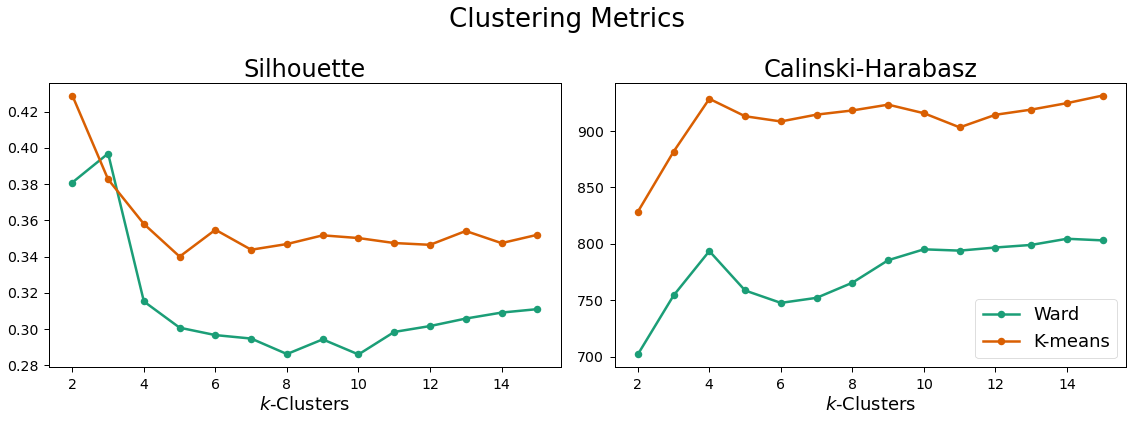

In [22]:
import matplotlib as mpl
from matplotlib import cm

fig,ax = plt.subplots(1,2, figsize=(16,6), sharex="col", 
    constrained_layout=True
    )

_models = ["Ward", "K-means", "DBSCAN"]
_metrics = ["Silhouette", "Calinski-Harabasz"]
for i, mod in enumerate(_models):
    if mod != "DBSCAN":
        for j, met in enumerate(_metrics):
            _qdf = res_pca[res_pca["pc"] == 2].query("model == @mod and metric == @met")
            ax[j].plot(_qdf["k"], _qdf["score"], "o-", label=f"{mod}", color=cm.Dark2(i))
            ax[j].set_title(f"{met}", size=24)
            ax[j].set_xlabel(r"$k$-Clusters", size=18)
ax[1].legend(fontsize=18)
            # if j==1 and i == 1:
            #     ax[j,i].legend(loc=(1.025,0.), title="PCs",
            #         #ncol=len(_qdf["pc"].unique())
            #         )
    # elif mod == "DBSCAN":
    #     for j, met in enumerate(_metrics):
    #         _qdf = res_pca[res_pca["pc"] == 2].query("model == @mod and metric == @met")
    #         _qqdf = _qdf[_qdf["pc"] == p]
    #         ax[j,i].plot(_qqdf["eps"], _qqdf["score"], "o-", label=f"{p}", color=cm.Dark2(c))
    #         if j == 0 and i == 2:
    #             for _x, _y, n in zip(_qqdf["eps"], _qqdf["score"], _qqdf["n_clusters"]):
    #                 ax[j,i].text(_x - 1, _y , n)
    #         ax[j,i].set_title(f"{mod} -- {met}", size=24)
    #         if j == 1:
    #             ax[j,i].set_xlabel(r"$\epsilon$", size=18)
    #         if j==1 and i == 2:
    #             #print("FOO")
    #             ax[j,i].set_xticks(res_dbscan["eps"][6:], labels=res_dbscan["eps"][6:], rotation=45, size=12)
    #             ax[j,i].legend(loc=(1.025,0.), title="PCs", title_fontsize=24, fontsize=24
    #                 #ncol=len(_qdf["pc"].unique())
    #                 )
#fig.legend(loc="best", )
fig.suptitle("Clustering Metrics", size=26)
fig.tight_layout()
#fig.savefig(f"../thesis/figures/impl/clustering/comparison_prasentation.png", dpi=160)

#fig.savefig("../thesis/figures/impl/clustering/pca_comparison_dbscan.png", dpi=320)

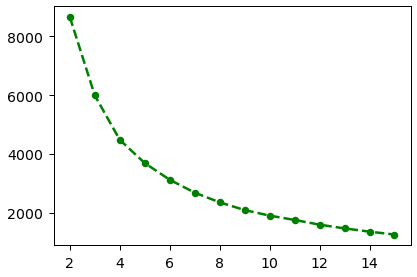

In [23]:
pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(random_state=seed, n_components=2)),
                ])
Xs = pipe.fit_transform(X)

kdistortions = []
for k in range(2,16):
    km = KMeans(init="k-means++", n_clusters=k, random_state=seed).fit(Xs)
    kdistortions.append(km.inertia_)

plt.plot(range(2,16), kdistortions, 'go--',)

In [24]:
pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(random_state=seed, n_components=2)),
                ])

Xs = pipe.fit_transform(X)
clustering = DBSCAN(eps=0.75).fit(Xs)
print("eps:0.75 -> ", set(clustering.labels_))

clustering = DBSCAN(eps=1).fit(Xs)
print("eps:1 -> ", set(clustering.labels_))

eps:0.75 ->  {0, 1, -1}
eps:1 ->  {0, -1}


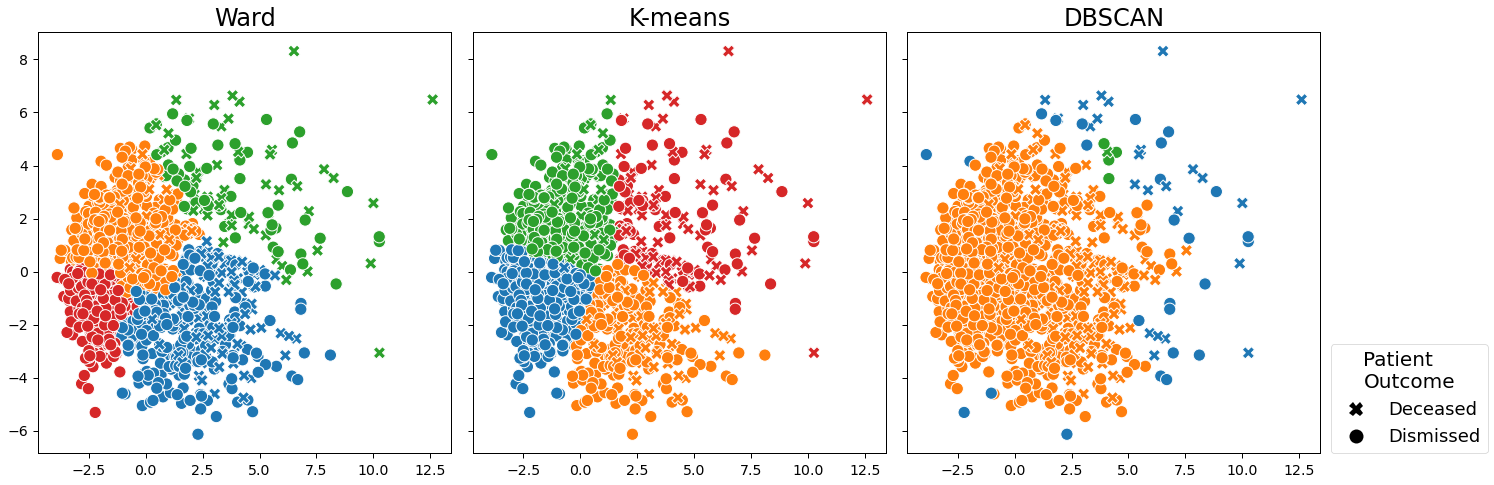

In [25]:
import matplotlib.lines as mlines

n_comp = 2
k=4
_cmap = {1: "#e41a1c", 2:"#377eb8", 3:"#4daf4a", 4:"#984ea3"}

ks = {"Ward": k, "K-means": k, "DBSCAN": 0.75}

# plt.style.use('seaborn-whitegrid')

# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 14}

# plt.rc('font', **font)


clusters_df = pd.DataFrame(columns=ks.keys())

pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(random_state=seed, n_components=n_comp)),
                ])

Xs = pipe.fit_transform(X)

fig, ax = plt.subplots(1,3, figsize=(21,7), sharey=True)

dec = mlines.Line2D([], [], color="w", marker='X',
                            markerfacecolor='black',
                            markersize=14, label='Deceased')
dismissed = mlines.Line2D([], [], color="w", marker='o',
                            markerfacecolor='black',
                            markersize=14, label='Dismissed')
                                                        

alg = ["Ward", "K-means", "DBSCAN"]
for i, model in enumerate(alg):
    if model == "Ward":
        c = AgglomerativeClustering(linkage="ward", n_clusters=ks[model]).fit_predict(Xs)
    elif model == "K-means":
        c = KMeans(init="k-means++", n_clusters=ks[model], random_state=seed).fit_predict(Xs)
    elif model == "DBSCAN":
        c = DBSCAN(eps=ks[model]).fit_predict(Xs)
        c = c+1
    #c = c+1
    clusters_df[model] = c
    #_cdf = clusters_df.sort_values(by=model, ascending=True)
    sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], s=150, hue_order=range(0,k),
                hue=c, palette=sns.color_palette()[:k], #palette=_cmap, #palette=cm.Dark2,
                ax=ax[i], style=ld.target_df["last.status"], legend=False)
    ax[i].set_title(f"{model}", size=24)
    if i == 2: # last ax
        ax[i].legend(loc=(1.025,0.), title="Patient\nOutcome",
                    title_fontsize=20, fontsize=18, handles=[dec, dismissed])

fig.tight_layout()
#fig.savefig("../thesis/figures/impl/clustering/cluster_comparison.png", dpi=320)
#plt.style.use('default')


Right side is more towards deceased patients, left side is made up of more or less healthier ones. 

## 3. t-SNE

In [26]:
# perps = range(10,100,20)
# lr = ["auto", 200, 500, 800]

# fig, ax = plt.subplots(4,5, figsize=(24,12, ),
#  sharex="col", #sharey="col",
# )
# for j, _lr in enumerate(lr):
#     for i, perp in enumerate(perps):
#         pipe = Pipeline([('scaler', StandardScaler()),
#                     ('tsne', TSNE(n_components=2, perplexity=perp,
#                     learning_rate=_lr, init="pca", random_state=seed)),
#                     #('kmeans', KMeans(init="k-means++", n_clusters=n_clusters))
#                     ])
#         Xs = pipe.fit_transform(X)
#         c = clusters_df["K-means"]
#         sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], s=50,
#                     hue=c, palette=sns.color_palette()[:k], hue_order=range(0,k),
#                     ax=ax[j, i], style=df_targets["last.status"], legend=False)
#         ax[j,i].set_title(f"p:{perp} - lr:{_lr}", size=16)
# fig.tight_layout()
# fig.savefig("../thesis/figures/impl/clustering/lr_perp_changes.png")

### Compare how the clusters look like after t-SNE

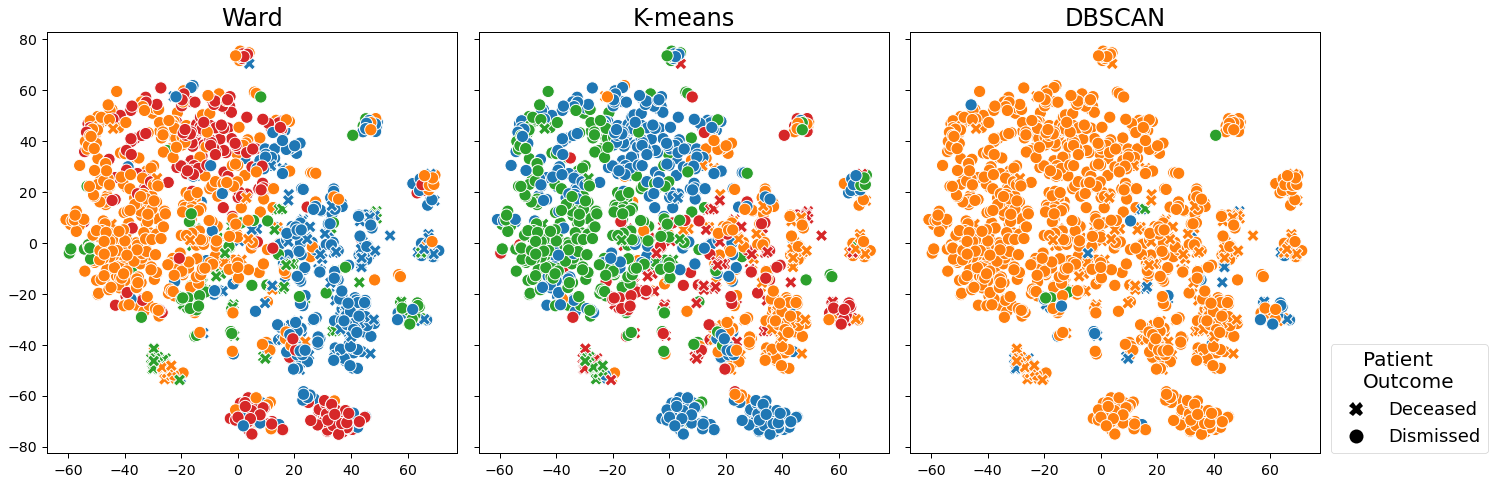

In [27]:
# plt.style.use('seaborn-whitegrid')

# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 14}

# plt.rc('font', **font)


alg = ["Ward", "K-means", "DBSCAN"]

fig, ax = plt.subplots(1,3, figsize=(21,7),
 sharex=True, sharey=True
)
dec = mlines.Line2D([], [], color="w", marker='X',
                            markerfacecolor='black',
                            markersize=14, label='Deceased')
dismissed = mlines.Line2D([], [], color="w", marker='o',
                            markerfacecolor='black',
                            markersize=14, label='Dismissed')

pipe = Pipeline([('scaler', StandardScaler()),
            ('tsne', TSNE(n_components=2, perplexity=10,
            learning_rate=500, init="pca", random_state=seed)),
            #('kmeans', KMeans(init="k-means++", n_clusters=n_clusters))
            ])
Xs = pipe.fit_transform(X)
for i, model in enumerate(alg):
    sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], s=150, hue=clusters_df[model],
            palette=sns.color_palette()[:k], hue_order=range(0,k),
            ax=ax[i], legend=False, style=df_targets["last.status"], #style=ld.ml_target_df["Outcome"]#style=df_targets["last.status"],
            )
    ax[i].set_title(f"{model}", size=24)
    if i == 2:
        ax[i].legend(loc=(1.025,0.), title="Patient\nOutcome",
            title_fontsize=20, fontsize=18, handles=[dec, dismissed])
#fig.suptitle("t-SNE", size=18)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/clustering/tsne_cluster_comparison.png")

We can see some divergences here, some smaller clouds occur and are covered differently by the clustering techniques. We should investigate if those clouds are artifacts from the imputation and if they occur when we use other imputation techniques as well! DBSCAN will not be used further since it's not really able to distinguish anything here, it tends to create few classes too early.

## 4. Compare Imputation strategies

### Try different imputation techniques

deletion strategy is not feasible - only 2 rows remain with no NaN!

In [28]:
import itertools

imps = ["nn",
 "mean", "median", 
 "mi",
 "iterative"
 ]

__i = [5, 10, 25]
__d = ["uniform", "distance"]
nn_settings = list(itertools.product(__i, __d))

pca_pipe = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(n_components=2, random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=n_clusters))
                 ])
tsne_pipe = Pipeline([('scaler', StandardScaler()),
                     ('tsne', TSNE(n_components=2, perplexity=10,
                          learning_rate="auto", init="pca", random_state=seed)),
                     ])

res_imp = pd.DataFrame()

def compute_metrics(_xs, imp, res_imp):
    alg = ["Ward", "K-means"]

    #fig, ax = plt.subplots(2, 2, figsize=(18,8))

    for i, model in enumerate(alg):
        k = range(2,16)
        scores_sil = []
        scores_cal = []
        for _k in k:
            if model == "Ward":
                clustering = AgglomerativeClustering(linkage="ward", n_clusters=_k).fit(_xs)
                scores_sil.append(metrics.silhouette_score(_xs, clustering.labels_))
                scores_cal.append(metrics.calinski_harabasz_score(_xs, clustering.labels_))
            else:
                clustering = KMeans(init="k-means++", n_clusters=_k, random_state=seed).fit(_xs)
                scores_sil.append(metrics.silhouette_score(_xs, clustering.predict(_xs)))
                scores_cal.append(metrics.calinski_harabasz_score(_xs, clustering.predict(_xs)))

        for s, m in zip([scores_sil, scores_cal], ["Silhouette", "Calinski-Harabasz"]):
            r = {"model" : model, "score" : s, "metric" : m,
                "k" : k, "imputation" : imp}
            res_imp = res_imp.append(pd.DataFrame(r))
    return res_imp


for imp in imps:
    if imp == "nn":
        for setting in nn_settings:
            _df = ld.process_features(return_df=True, numeric_mode=imp, k_nearest=setting[0], k_distance=setting[1])
            _x = _df.drop(targets, axis=1) #"Acute.Kidney.Injury..during.hospitalization.", "Acute.Hepatic.Injury..during.hospitalization."
            _imp = imp+f"-{setting[0]}-{setting[1]}"
            print(f"{_imp}: {_x.shape}")
            _xs = pca_pipe.fit_transform(_x)
            res_imp = compute_metrics(_xs, _imp, res_imp)
    elif imp == "mi":
        #for mival in [-1, 0, 1]:
        for mival in [0]:
            _df = ld.process_features(return_df=True, binary_mode=imp, numeric_mode=imp)
            _x = _df.drop(targets, axis=1) #"Acute.Kidney.Injury..during.hospitalization.", "Acute.Hepatic.Injury..during.hospitalization."
            _xs = pca_pipe.fit_transform(_x)
            _imp = imp+f"-{mival}"
            print(f"{imp}: {_x.shape}")
            res_imp = compute_metrics(_xs, _imp, res_imp)
    else:
        _df = ld.process_features(return_df=True, binary_mode=imp, numeric_mode=imp)
        _x = _df.drop(targets, axis=1) #"Acute.Kidney.Injury..during.hospitalization.", "Acute.Hepatic.Injury..during.hospitalization."
        _xs = pca_pipe.fit_transform(_x)
        print(f"{imp}: {_x.shape}")
        res_imp = compute_metrics(_xs, imp, res_imp)

nn-5-uniform: (1279, 75)
nn-5-distance: (1279, 75)
nn-10-uniform: (1279, 75)
nn-10-distance: (1279, 75)
nn-25-uniform: (1279, 75)
nn-25-distance: (1279, 75)
mean: (1279, 75)
median: (1279, 75)
mi: (1279, 75)
iterative: (1279, 75)


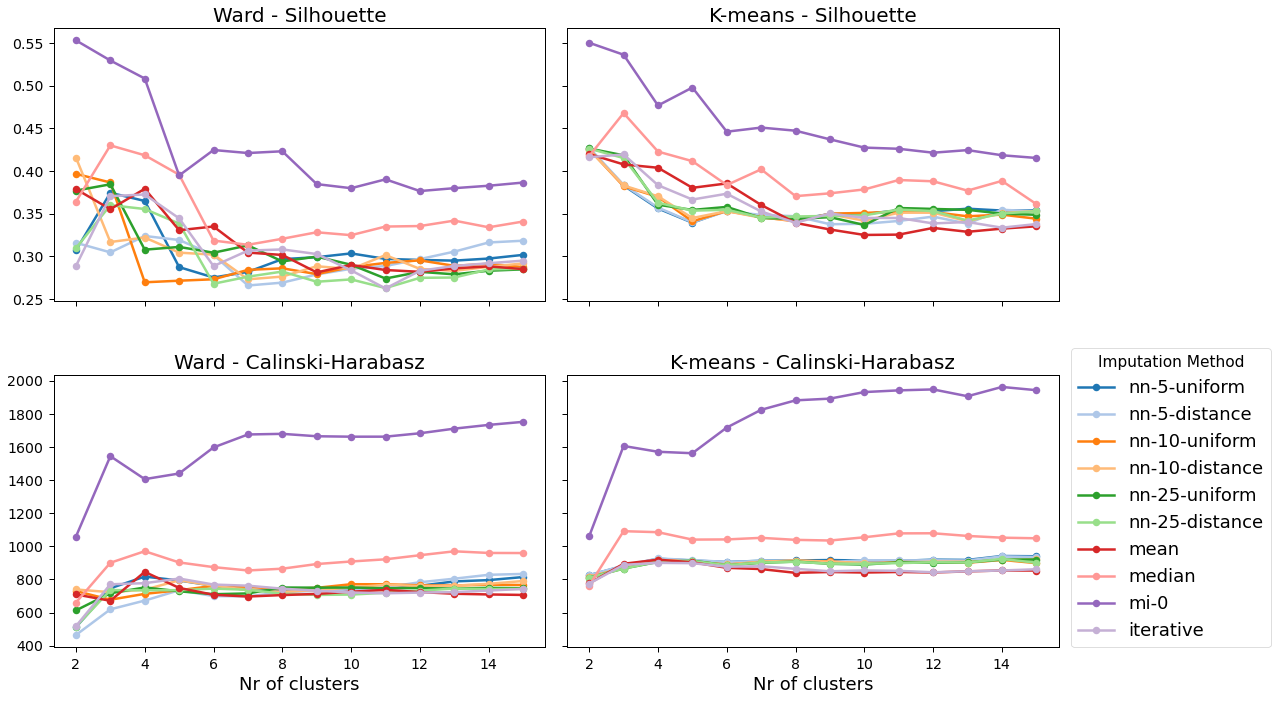

In [29]:
#sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5, "lines.markersize" : 7.5})

fig,ax = plt.subplots(2,2, figsize=(18,10), sharex=True, sharey="row")

_models = ["Ward", "K-means"]
_metrics = ["Silhouette", "Calinski-Harabasz"]
for i, mod in enumerate(_models):
    for j, met in enumerate(_metrics):
        _qdf = res_imp.query("model == @mod and metric == @met")
        for c, p in enumerate(_qdf["imputation"].unique()):
            _qqdf = _qdf[_qdf["imputation"] == p]
            ax[j,i].plot(_qqdf["k"], _qqdf["score"], "o-", label=f"{p}", 
                color=cm.tab20(c)
                #color=tab10_b[c-1]
            )
        ax[j,i].set_title(f"{mod} - {met}", size=20)
        if j == 1:
            ax[j,i].set_xlabel("Nr of clusters", size=18)
        if j==1 and i == 1:
            ax[j,i].legend(loc=(1.025,0.), title="Imputation Method", fontsize=18
                #ncol=len(_qdf["perplexity"].unique())
                )
#fig.legend(loc="best", )
fig.tight_layout()
#fig.savefig("../thesis/figures/impl/clustering/imputation_comp.png", dpi=320)

K-means performs better and is thus prefered. MI and nn-5/10 look best here with 3+ clusters

---

## Finish this


In [30]:
seed = 42

In [31]:
k = 4

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=2, random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=k, random_state=seed))
                 ])

tsne_pipe = Pipeline([('scaler', StandardScaler()),
                    ('tsne', TSNE(n_components=2, perplexity=10,
                        learning_rate=500, init="pca", random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=k, random_state=seed))
                 ])


Xs = pipe.fit_transform(X)
clusters = KMeans(init="k-means++", n_clusters=k, random_state=seed).fit_predict(Xs)
clusters = clusters+1 # increment by one for readability and everything later on...

Xs = tsne_pipe.fit_transform(X)
#X["cluster"] = clusters
#X.to_csv(fpath, ignore_index=True)

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


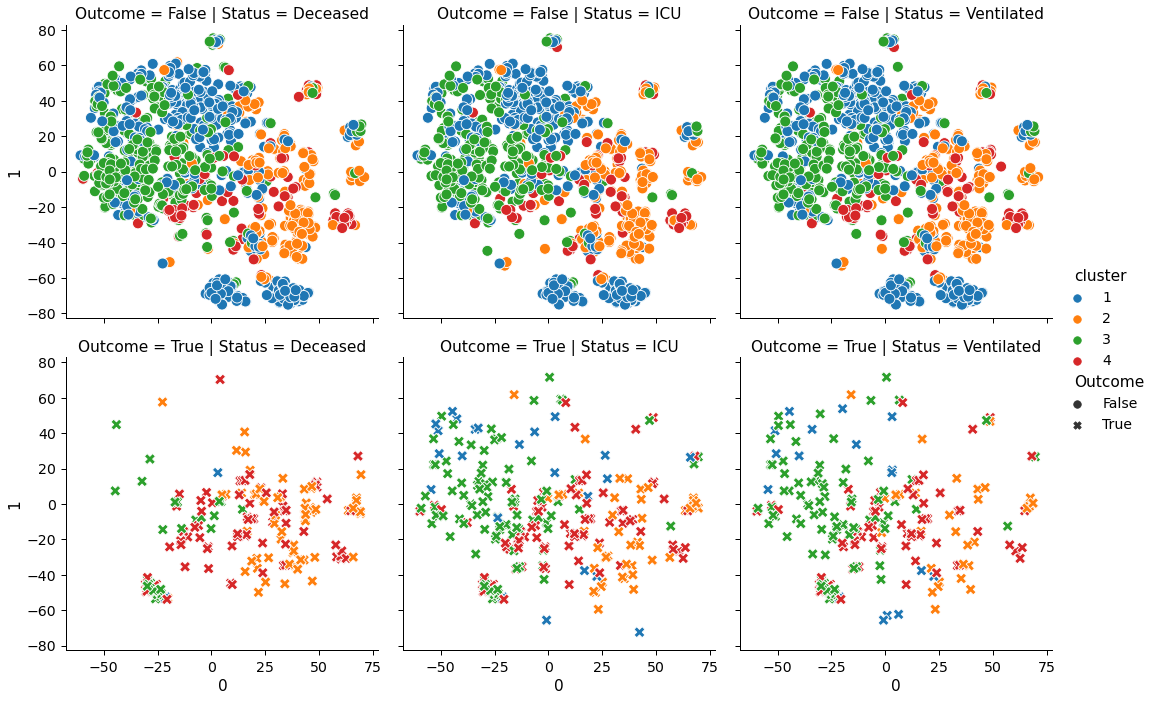

In [32]:
_pdf = pd.concat([pd.DataFrame(Xs), ld.target_df, pd.DataFrame(clusters, columns=["cluster"])], axis=1)

_pdfs = []
for i, t in enumerate(targets):
    #print(i,t)
    __pdf = _pdf[[0,1,t,"cluster"]]
    if i == 0: 
        __pdf["Status"] = "Deceased"
        __pdf["Outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    elif i == 1:
        __pdf["Status"] = "ICU"
        __pdf["Outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    elif i == 2:
        __pdf["Status"] = "Ventilated"
        __pdf["Outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    _pdfs.append(__pdf)

_ppdf = pd.concat(_pdfs)
_ppdf["Outcome"].replace({0:"False", 1:"True"}, inplace=True)

p = sns.relplot(data=_ppdf, x=0, y=1, col="Status", row="Outcome",
 s=120, hue="cluster", style="Outcome",
 palette=sns.color_palette()[:k], hue_order=range(1,k+1)
)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


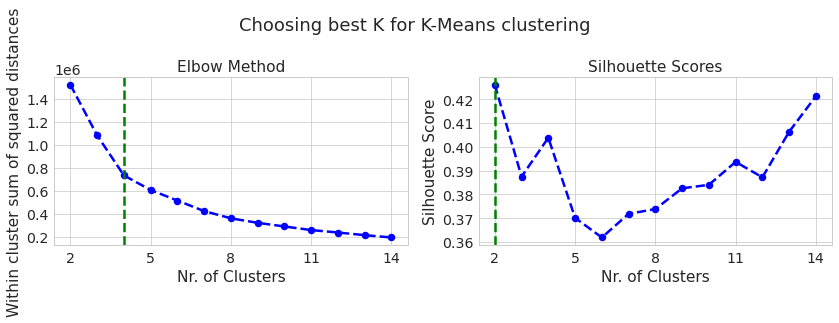

In [33]:
#plt.style.use('seaborn-paper')
plt.style.use('seaborn-whitegrid')

font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

k = 9
kmax = 15

fig, ax = plt.subplots(1,2,figsize=(12,4))

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=2, random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=k, random_state=seed))
                 ])

pd.DataFrame(Xs).to_csv("data/clustering/pca_reduced.csv", index=False)

kdistortions = []
scores = []

for _k in range(2,kmax):
    km = KMeans(init="k-means++", n_clusters=_k, random_state=seed).fit(Xs)
    kdistortions.append(km.inertia_)
    scores.append(metrics.silhouette_score(Xs, km.fit_predict(Xs)))
ax[0].plot(range(2,kmax), kdistortions, 'bo--',)
ax[0].set_xticks(range(2,kmax, 3))
ax[0].set_xlabel("Nr. of Clusters")
ax[0].set_ylabel("Within cluster sum of squared distances")
ax[0].set_title("Elbow Method")
l1 = ax[0].axvline(4, color="g", ls="--")

ax[1].plot(range(2,kmax), scores, 'bo--',)
ax[1].set_xticks(range(2,kmax, 3))
ax[1].set_xlabel("Nr. of Clusters")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Silhouette Scores")
l1 = ax[1].axvline(2, color="g", ls="--")


fig.suptitle("Choosing best K for K-Means clustering", fontsize=18)

fig.tight_layout()
#fig.savefig("../thesis/figures/impl/clustering/best_k.png", dpi=180)

plt.style.use('default')


In [34]:
_cmap = sns.xkcd_palette(["teal", "periwinkle", "navy blue", "bright blue"])
_cmap

[(0.00784313725490196, 0.5764705882352941, 0.5254901960784314),
 (0.5568627450980392, 0.5098039215686274, 0.996078431372549),
 (0.0, 0.06666666666666667, 0.27450980392156865),
 (0.00392156862745098, 0.396078431372549, 0.9882352941176471)]

In [35]:
_cmap = {'Hospitalized (only)' :        "#31a354",
 'ICU':                         "#fc9272",
 'Ventilated' :                 "#bdbdbd",
 'ICU + Vent' :                 sns.xkcd_rgb["burgundy"],#"#de2d26",
 'Deceased' :                   sns.xkcd_rgb["bright blue"],
 'Deceased + ICU' :             sns.xkcd_rgb["violet"],
 'Deceased + Ventilated' :      sns.xkcd_rgb["royal purple"],
 'Deceased + ICU + Ventilated' : sns.xkcd_rgb["navy blue"],
 }

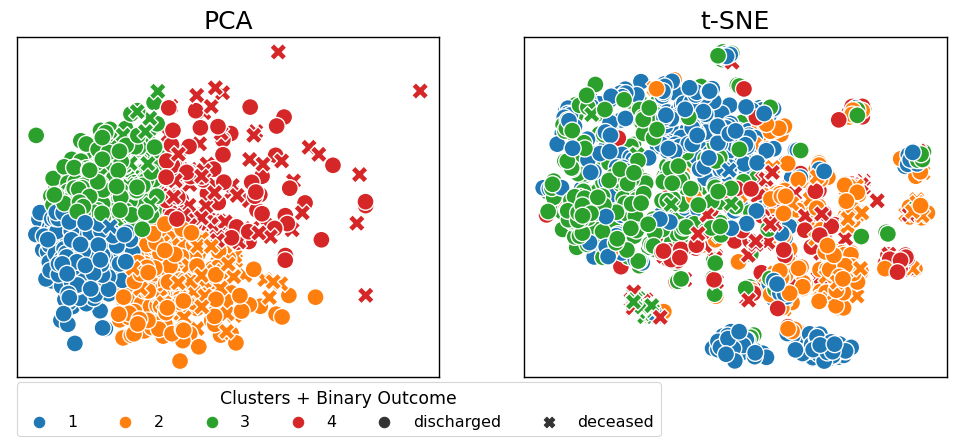

In [36]:
k = 4

sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5, "lines.markersize" : 7.5})
# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 14}

# plt.rc('font', **font)

fig, ax = plt.subplots(1, 2, figsize=(12,5))

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=2, random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=k, random_state=seed))
                 ])

tsne_pipe = Pipeline([('scaler', StandardScaler()),
                    ('tsne', TSNE(n_components=2, perplexity=10,
                        learning_rate=500, init="pca", random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=k, random_state=seed))
                 ])

Xs = pipe.fit_transform(X)

clusters = KMeans(init="k-means++", n_clusters=k, random_state=seed).fit_predict(Xs)
clusters = clusters+1 # increment by one for readability and everything later on...
clusters_str = [f"Cluster {_c}" for _c in clusters]
sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], s=150, hue=clusters,
            palette=sns.color_palette()[:k], hue_order=range(1,k+1),
            legend=True, style=ld.raw_ehd["last.status"], #style=ld.ml_target_df["Outcome"]#style=df_targets["last.status"],
            ax=ax[0]
            )
ax[0].set_title("PCA", size=18)

Xs_tsne = tsne_pipe.fit_transform(X)

sns.scatterplot(x=Xs_tsne[:, 0], y=Xs_tsne[:, 1], s=150, hue=clusters,
            palette=sns.color_palette()[:k], hue_order=range(1,k+1),
            legend=False, style=ld.raw_ehd["last.status"], #style=ld.ml_target_df["Outcome"]#style=df_targets["last.status"],
            ax=ax[1]
            )
ax[1].set_title("t-SNE", size=18)

# clusters = KMeans(init="k-means++", n_clusters=5, random_state=seed).fit_predict(Xs)
# clusters = clusters+1 # increment by one for readability and everything later on...
# sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], s=150, hue=clusters,
#             palette=sns.color_palette()[:5], hue_order=range(1,5+1),
#             legend=False, style=df_targets["last.status"], #style=ld.ml_target_df["Outcome"]#style=df_targets["last.status"],
#             ax=ax[1]
#             )

for i in range(0,len(ax)):
    ax[i].set_yticks([])
    ax[i].set_xticks([])

#fig.tight_layout(rect=(0,2,0,0))
#fig.tight_layout(rect=(0,0,1,1))
#fig.tight_layout(h_pad=4)

ax[0].legend(#["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Dismissed", "Deceased"],
    loc=(0.0,-0.175), title="Clusters + Binary Outcome", #fontsize=16,
    ncol=8
    )
leg = ax[0].get_legend()
title = leg.get_title()
#title.set_size(12)
#title.set_x(-100)
#title.set_y(-25)
#title.set_rotation(90)
#leg.set_in_layout(False)

#fig.tight_layout(rect=(0.0, 0.2, 1, 0.8))
#fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
#fig.savefig("../thesis/figures/impl/clustering/final_k-means_180.png", dpi=180) # i manually cropped this afterwards hrrrrr

plt.style.use('default')


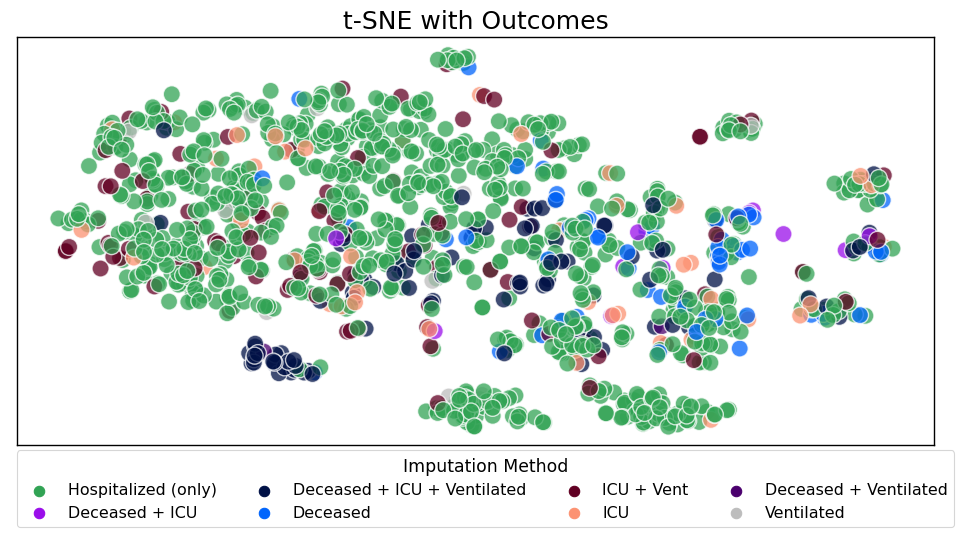

In [37]:
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5, "lines.markersize" : 7.5})

fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.scatterplot(x=Xs_tsne[:, 0], y=Xs_tsne[:, 1], s=150,
    hue=ld.ml_target_df["Outcome"], palette=_cmap, alpha=0.75,
    legend=True, ax=ax
    )
ax.set_title("t-SNE with Outcomes", size=18)

fig.tight_layout()

ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc=(0.0,-0.2), title="Imputation Method", #fontsize=16,
    ncol=4
    )
plt.style.use('default')

/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

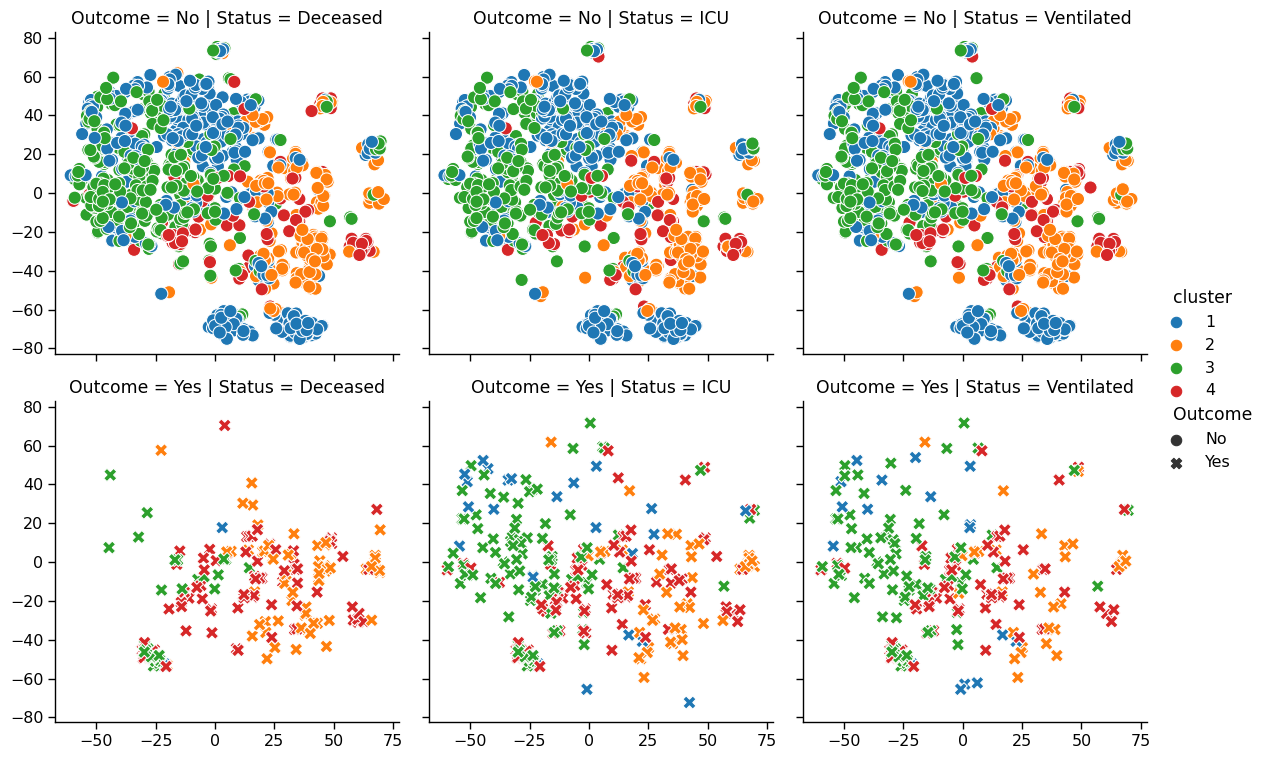

In [38]:
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5, "lines.markersize" : 7.5})

clusters = KMeans(init="k-means++", n_clusters=k, random_state=seed).fit_predict(Xs)
clusters = clusters+1 # increment by one for readability and everything later on...

tsne_pipe = Pipeline([('scaler', StandardScaler()),
                    ('tsne', TSNE(n_components=2, perplexity=10,
                        learning_rate=500, init="pca", random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=k, random_state=seed))
                 ])

Xstsne = tsne_pipe.fit_transform(X)
#X["cluster"] = clusters
#X.to_csv(fpath, ignore_index=True)

_pdf = pd.concat([pd.DataFrame(Xstsne), ld.target_df, pd.DataFrame(clusters, columns=["cluster"])], axis=1)

_pdfs = []
for i, t in enumerate(targets):
    #print(i,t)
    __pdf = _pdf[[0,1,t,"cluster"]]
    if i == 0: 
        __pdf["Status"] = "Deceased"
        __pdf["Outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    elif i == 1:
        __pdf["Status"] = "ICU"
        __pdf["Outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    elif i == 2:
        __pdf["Status"] = "Ventilated"
        __pdf["Outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    _pdfs.append(__pdf)

_ppdf = pd.concat(_pdfs)
_ppdf["Outcome"].replace({0:"No", 1:"Yes"}, inplace=True)

p = sns.relplot(data=_ppdf, x=0, y=1, col="Status", row="Outcome",
 s=90, hue="cluster", style="Outcome",
 palette=sns.color_palette()[:k], hue_order=range(1,k+1), height=4
)
p.set_axis_labels("","")
fig.tight_layout()
#fig.savefig("../thesis/figures/impl/clustering/binary_targets_relplot.png", dpi=180)


Only one in blue is in deceased..

In [39]:
# save clusters
import joblib
fpath = "data/clusters.pkl"
if not os.path.exists(fpath):
    joblib.dump(clusters, fpath)

In [40]:
ld.ml_target_df

y labelstring                      Outcome
0     0         000          Hospitalized (only)
1     6         110               Deceased + ICU
2     7         111  Deceased + ICU + Ventilated
3     7         111  Deceased + ICU + Ventilated
4     0         000          Hospitalized (only)
...  ..         ...                          ...
1274  0         000          Hospitalized (only)
1275  0         000          Hospitalized (only)
1276  0         000          Hospitalized (only)
1277  0         000          Hospitalized (only)
1278  0         000          Hospitalized (only)

[1279 rows x 3 columns]

In [41]:
X_fin = X.copy()
X_fin["cluster"] = clusters

sums = pd.concat([X_fin["cluster"], pd.get_dummies(ld.ml_target_df["Outcome"])], axis=1).groupby("cluster").sum()
count = pd.concat([X_fin["cluster"], pd.get_dummies(ld.ml_target_df["Outcome"])], axis=1).groupby("cluster").count()

props_df = (sums / count).round(3)*100
props_df.T
#((pd.concat([X_fin["cluster"], ld.ml_target_df["y"]], axis=1).groupby("cluster").sum() / pd.concat([X_fin["cluster"], ld.ml_target_df["y"]], axis=1).groupby("cluster").count()).round(3)*100)

cluster                         1     2     3     4
Deceased                      0.0  16.9   0.5  10.2
Deceased + ICU                0.0   1.6   0.3   3.8
Deceased + ICU + Ventilated   0.6   6.7   6.9  34.4
Deceased + Ventilated         0.0   0.0   0.3   0.6
Hospitalized (only)          94.3  64.6  71.2  33.8
ICU                           2.0   4.7   4.0   5.7
ICU + Vent                    2.2   4.7  15.6  11.5
Ventilated                    0.8   0.8   1.3   0.0

In [42]:
d = dict(pd.concat([X_fin["cluster"], ld.ml_target_df["Outcome"]], axis=1).value_counts())
outcomes = ld.ml_target_df["Outcome"].unique()
#cluster_outcomes_df = pd.DataFrame(index=(outcomes,range[1,5]), columns=["val", "cluster"])
cluster_outcomes_df = pd.DataFrame()
outcomes_counts = ld.ml_target_df["Outcome"].value_counts()
for k,v in d.items():
    curr_cluster = k[0]
    curr_outcome = k[1]
    val = v / outcomes_counts[curr_outcome]
    _d = {"Outcome":[curr_outcome], "Cluster":[f"{curr_cluster}"], "val":[val]}
    cluster_outcomes_df = pd.concat([cluster_outcomes_df, pd.DataFrame.from_records(_d)])

#pd.DataFrame.from_records(_d)
cluster_outcomes_df[cluster_outcomes_df["Outcome"] == "Hospitalized (only)"]["val"].sum()

1.0

In [43]:
d = dict(pd.concat([X_fin["cluster"], ld.ml_target_df["Outcome"]], axis=1).value_counts())
outcomes = ld.ml_target_df["Outcome"].unique()
cluster_outcomes_df = pd.DataFrame(index=outcomes, columns=range(1,5))
outcomes_counts = ld.ml_target_df["Outcome"].value_counts()
for k,v in d.items():
    curr_cluster = k[0]
    curr_outcome = k[1]

    cluster_outcomes_df.loc[curr_outcome, curr_cluster] = v / outcomes_counts[curr_outcome]
cluster_outcomes_df = cluster_outcomes_df.fillna(0.0).round(3)
#cluster_outcomes_df = cluster_outcomes_df.reset_index().rename(columns={"index":"Outcome"})
cluster_outcomes_df

1      2      3      4
Hospitalized (only)          0.487  0.173  0.284  0.056
Deceased + ICU               0.000  0.364  0.091  0.545
Deceased + ICU + Ventilated  0.030  0.170  0.260  0.540
Deceased                     0.000  0.705  0.033  0.262
ICU + Vent                   0.110  0.120  0.590  0.180
ICU                          0.217  0.261  0.326  0.196
Deceased + Ventilated        0.000  0.000  0.500  0.500
Ventilated                   0.364  0.182  0.455  0.000

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


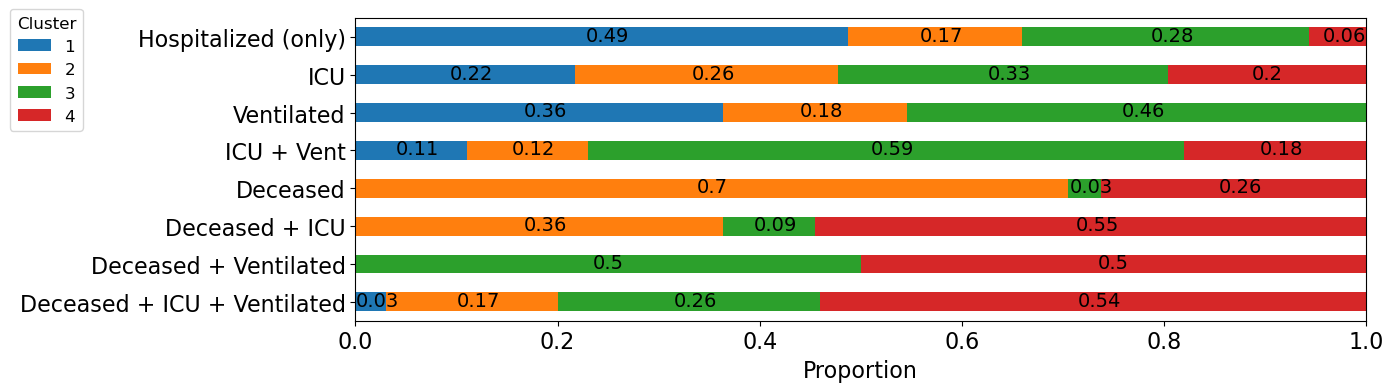

In [44]:
plt.style.use('default')

font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

fig,ax = plt.subplots(1,1, figsize=(14, 4)) # figsize=(8,4)
_ordering = ["Hospitalized (only)", 
    "ICU", "Ventilated", "ICU + Vent",
    "Deceased", "Deceased + ICU", "Deceased + Ventilated", 
    "Deceased + ICU + Ventilated"]
cluster_outcomes_df.loc[_ordering[::-1],:].plot(kind="barh", stacked=True, legend=False,
                        ax=ax, xlim=(0,1))
# for container in ax.containers:
#     print(container)
#     ax.bar_label(container, padding=2)
for p in ax.patches:
    if p.get_width() > 0.0:
        _value = round(p.get_width(),2)
        ax.annotate(str(_value), (p.get_x() + p.get_width()/2, p.get_y()),
                    xytext=(-11, 4), textcoords='offset points', fontsize=14,
                    #rotation=90
                    )
        #ax.annotate(str(_value), (p.get_x() + p.get_width()/2, p.get_y()), xytext=(0, 5), textcoords='offset points')
ax.set_xlabel("Proportion", size=16)
#ax.set_yticks(ax.get_yticks(), fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig.tight_layout()
ax.legend(title="Cluster", loc="lower left", bbox_to_anchor=(-0.35, .6))



#fig.savefig("../thesis/figures/impl/clustering/multi_targets_per_cluster.png", dpi=180)
#fig.savefig("../thesis/figures/impl/clustering/multi_targets_per_cluster_annotated.png", dpi=180)

In [45]:
X_fin["Outcome"] = ld.ml_target_df["Outcome"]
_d = dict(X_fin[["Outcome", "cluster"]].value_counts())
_countdf = pd.DataFrame(index=X_fin["Outcome"].unique(), columns=X_fin["cluster"].unique())
for k,v in _d.items():
    _out = k[0]
    _c = k[1]
    _countdf.at[_out,_c] = v
#_countdf.fillna(0)[[1,2,3,4]]
#_countdf.columns = pd.MultiIndex.from_product([["Cluster"], _countdf.columns])
_countdf.fillna(0).loc[ld.ml_ordering,[1,2,3,4]]

1    2    3   4
Hospitalized (only)          462  164  269  53
ICU                           10   12   15   9
Ventilated                     4    2    5   0
ICU + Vent                    11   12   59  18
Deceased                       0   43    2  16
Deceased + ICU                 0    4    1   6
Deceased + Ventilated          0    0    1   1
Deceased + ICU + Ventilated    3   17   26  54

In [46]:
_boolean = ld.pre_known_features_onehot.copy()
## remove known non-boolean cols
_boolean.remove("Body mass index (BMI) [Ratio]")
_boolean.remove("Oral temperature")
## add known non-numeric cols

_boolean = _boolean + ['Urine.protein_Abnormal', 'Urine.protein_Normal', 'Urine.protein_nan',
                     'Microscopic_hematuria.above2', 'Proteinuria.above80']
_boolean = sorted(_boolean, key=lambda v: v.lower())

In [47]:
X_fin.head()

kidney_replacement_therapy  kidney_transplant  htn_v  dm_v  cad_v  ckd_v  \
0                         0.0                0.0    0.6   0.4    0.6    0.4   
1                         0.0                0.0    0.6   0.0    0.0    0.0   
2                         0.0                0.0    1.0   0.0    1.0    0.0   
3                         0.0                0.0    1.0   1.0    1.0    1.0   
4                         0.0                0.0    0.0   0.0    0.0    0.0   

   malignancies_v  copd_v  other_lung_disease_v  acei_v  ...  hf_ef_v_HFpEF  \
0             0.2     0.0          2.000000e-01     0.0  ...            0.0   
1             0.2     0.0         -2.775558e-17     0.2  ...            0.0   
2             0.0     1.0          1.000000e+00     0.0  ...            0.0   
3             0.0     1.0          0.000000e+00     0.0  ...            0.0   
4             0.0     0.0          0.000000e+00     0.0  ...            1.0   

   hf_ef_v_HFrEF  hf_ef_v_No  hf_ef_v_nan  smoking_status_v_Current  \
0            0.0         0.0          1.0                       0.0   
1            0.0         0.0          1.0                       0.0   
2            0.0         1.0          0.0                       0.0   
3            1.0         0.0          0.0                       0.0   
4            0.0         0.0          0.0                       0.0   

   smoking_status_v_Former  smoking_status_v_Never  smoking_status_v_nan  \
0                      0.0                     0.0                   1.0   
1                      0.0                     0.0                   1.0   
2                      0.0                     1.0                   0.0   
3                      1.0                     0.0                   0.0   
4                      0.0                     1.0                   0.0   

   cluster                      Outcome  
0        2          Hospitalized (only)  
1        4               Deceased + ICU  
2        4  Deceased + ICU + Ventilated  
3        4  Deceased + ICU + Ventilated  
4        1          Hospitalized (only)  

[5 rows x 76 columns]

In [48]:
X_fin

kidney_replacement_therapy  kidney_transplant  htn_v  dm_v  cad_v  \
0                            0.0                0.0    0.6   0.4    0.6   
1                            0.0                0.0    0.6   0.0    0.0   
2                            0.0                0.0    1.0   0.0    1.0   
3                            0.0                0.0    1.0   1.0    1.0   
4                            0.0                0.0    0.0   0.0    0.0   
...                          ...                ...    ...   ...    ...   
1274                         0.0                0.0    0.0   0.0    0.0   
1275                         0.0                0.0    0.2   0.0    0.0   
1276                         0.0                0.0    0.2   0.2    0.0   
1277                         0.0                0.0    0.4   0.2    0.0   
1278                         0.0                0.0    0.0   0.0    0.0   

      ckd_v  malignancies_v  copd_v  other_lung_disease_v  acei_v  ...  \
0       0.4             0.2     0.0          2.000000e-01     0.0  ...   
1       0.0             0.2     0.0         -2.775558e-17     0.2  ...   
2       0.0             0.0     1.0          1.000000e+00     0.0  ...   
3       1.0             0.0     1.0          0.000000e+00     0.0  ...   
4       0.0             0.0     0.0          0.000000e+00     0.0  ...   
...     ...             ...     ...                   ...     ...  ...   
1274    0.0             0.0     0.0         -2.775558e-17     0.0  ...   
1275    0.0             0.0     0.0         -2.775558e-17     0.0  ...   
1276    0.0             0.0     0.0          2.000000e-01     0.0  ...   
1277    0.0             0.2     0.0          4.000000e-01     0.0  ...   
1278    0.0             0.0     0.0         -2.775558e-17     0.0  ...   

      hf_ef_v_HFpEF  hf_ef_v_HFrEF  hf_ef_v_No  hf_ef_v_nan  \
0               0.0            0.0         0.0          1.0   
1               0.0            0.0         0.0          1.0   
2               0.0            0.0         1.0          0.0   
3               0.0            1.0         0.0          0.0   
4               1.0            0.0         0.0          0.0   
...             ...            ...         ...          ...   
1274            0.0            0.0         0.0          1.0   
1275            0.0            0.0         0.0          1.0   
1276            0.0            0.0         0.0          1.0   
1277            0.0            0.0         0.0          1.0   
1278            0.0            0.0         0.0          1.0   

      smoking_status_v_Current  smoking_status_v_Former  \
0                          0.0                      0.0   
1                          0.0                      0.0   
2                          0.0                      0.0   
3                          0.0                      1.0   
4                          0.0                      0.0   
...                        ...                      ...   
1274                       0.0                      0.0   
1275                       0.0                      0.0   
1276                       0.0                      0.0   
1277                       0.0                      0.0   
1278                       0.0                      0.0   

      smoking_status_v_Never  smoking_status_v_nan  cluster  \
0                        0.0                   1.0        2   
1                        0.0                   1.0        4   
2                        1.0                   0.0        4   
3                        0.0                   0.0        4   
4                        1.0                   0.0        1   
...                      ...                   ...      ...   
1274                     0.0                   1.0        1   
1275                     0.0                   1.0        1   
1276                     0.0                   1.0        1   
1277                     0.0                   1.0        1   
1278                     0.0                   1.0       

In [49]:
#_xmeldet = pd.melt(X_fin, id_vars=["cluster"], value_vars=[_boolean])
X_fin_melted = pd.melt(X_fin.drop("Outcome", axis=1), id_vars=["cluster"])
#X_fin_melted["variable"] = X_fin_melted["variable"].str.lower()

In [50]:
X_fin_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_fin.drop(["Outcome", "cluster"], axis=1)), columns=X_fin.drop(["Outcome", "cluster"], axis=1).columns.values.tolist())
X_fin_scaled["cluster"] = X_fin["cluster"]
X_fin_scaled["Outcome"] = X_fin["Outcome"]
X_fin_scaled.head()

kidney_replacement_therapy  kidney_transplant  htn_v  dm_v  cad_v  ckd_v  \
0                         0.0                0.0    0.6   0.4    0.6    0.4   
1                         0.0                0.0    0.6   0.0    0.0    0.0   
2                         0.0                0.0    1.0   0.0    1.0    0.0   
3                         0.0                0.0    1.0   1.0    1.0    1.0   
4                         0.0                0.0    0.0   0.0    0.0    0.0   

   malignancies_v  copd_v  other_lung_disease_v  acei_v  ...  hf_ef_v_HFpEF  \
0             0.2     0.0          2.000000e-01     0.0  ...            0.0   
1             0.2     0.0          0.000000e+00     0.2  ...            0.0   
2             0.0     1.0          1.000000e+00     0.0  ...            0.0   
3             0.0     1.0          2.775558e-17     0.0  ...            0.0   
4             0.0     0.0          2.775558e-17     0.0  ...            1.0   

   hf_ef_v_HFrEF  hf_ef_v_No  hf_ef_v_nan  smoking_status_v_Current  \
0            0.0         0.0          1.0                       0.0   
1            0.0         0.0          1.0                       0.0   
2            0.0         1.0          0.0                       0.0   
3            1.0         0.0          0.0                       0.0   
4            0.0         0.0          0.0                       0.0   

   smoking_status_v_Former  smoking_status_v_Never  smoking_status_v_nan  \
0                      0.0                     0.0                   1.0   
1                      0.0                     0.0                   1.0   
2                      0.0                     1.0                   0.0   
3                      1.0                     0.0                   0.0   
4                      0.0                     1.0                   0.0   

   cluster                      Outcome  
0        2          Hospitalized (only)  
1        4               Deceased + ICU  
2        4  Deceased + ICU + Ventilated  
3        4  Deceased + ICU + Ventilated  
4        1          Hospitalized (only)  

[5 rows x 76 columns]

In [51]:
import plotly.express as px
import plotly.graph_objects as go


cmap = sns.color_palette()
_colors = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
(1.0, 0.4980392156862745, 0.054901960784313725),
(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)]
colors = []
for c in _colors:
    s = "rgb("
    for i in c:
        s += str(round(i*255)) + ","
    s = s[:-1] 
    s += ")"
    colors.append(s)
colors

['rgb(31,119,180)', 'rgb(255,127,14)', 'rgb(44,160,44)', 'rgb(214,39,40)']

In [132]:
_d = X_fin[_boolean + ["cluster"]].groupby("cluster").mean()
fig = px.bar(_d.T, color_discrete_sequence=colors)
fig.update_layout(
        margin=dict(
            l=10,
            r=10,
            b=10,
            t=5,
            pad=4
        ),
        height=680,
        width=1080,
        plot_bgcolor='rgba(0,0,0,0)',
        legend=dict(
            title="Cluster",
            orientation="h",
            yanchor="top",
            y= 0.97,#-0.09,
            xanchor="left",
            x=0.77,
            bgcolor="rgba(255,255,255,0.7)",
        ),
        xaxis= {
            "title": "",
            #'dtick': 1,
            'visible': True,
            'tickangle':90,
            #'ticks' : "outside",
            #'showticklabels': False,
        },
        yaxis= {
            "title": "",
            "range": [0,4],
            #'dtick': 1,
            #'visible': False,
            #'ticks' : "outside",
            'showticklabels': True,
            #"gridcolor": "#111"
        },
    template="simple_white",
    )
fig.update_yaxes(showgrid=True, gridwidth=1.4, gridcolor='#bbb')
fig.write_image("../thesis/figures/impl/clustering/boolean_per_cluster_barplot.png")
fig.show()

In [103]:
_d.filter(regex="Troponin") 

Troponin T.cardiac [Mass/volume] in Serum or Plasma
cluster                                                     
1                                                 0.012690  
2                                                 0.042118  
3                                                 0.011529  
4                                                 0.081045

In [136]:
_d = X_fin.drop(_boolean + ["Outcome"], axis=1).groupby("cluster").mean()
#_dlog = _d
_dlog = np.log2(_d)

_dlog.rename({
    "Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)":
    "Glomerular filtration rate/1.73 in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)"
    }, axis=1, inplace=True)

_dlog["Troponin T.cardiac [Mass/volume] in Serum or Plasma"] = _dlog.filter(regex="Troponin") *-1

# remove serum plasma shit
cols = _dlog.columns
_newcols = []
for col in cols:
    if "in Serum or Plasma" in col:
        col = col.replace("in Serum or Plasma", "")
        col += "*"
    elif "in Serum, Plasma or Blood" in col:
        col = col.replace("in Serum, Plasma or Blood", "")
        col += "**"
    elif "Leukocytes" in col:
        col = "Leukocytes [#/volume]***"
    _newcols.append(col)
_dlog.columns = _newcols

cols = _dlog.columns
cols = sorted(cols)

fig = px.bar(_dlog[cols].T, color_discrete_sequence=colors)
fig.update_layout(
        margin=dict(
            l=10,
            r=10,
            b=10,
            t=5,
            pad=4
        ),
        height=800,
        width=1280,
        plot_bgcolor='rgba(0,0,0,0)',
        legend=dict(
            title="Cluster",
            orientation="h",
            yanchor="top",
            y= 0.89,#-0.09,
            xanchor="left",
            x=0.77,
            bgcolor="rgba(255,255,255,0.7)",
        ),
        xaxis= {
            "title": "",
            #'dtick': 1,
            'visible': True,
            'tickangle':90,
            #'ticks' : "outside",
            #'showticklabels': False,
        },
        yaxis= {
            "title": "",
            #"range": [0,4],
            #'dtick': 1,
            #'visible': False,
            #'ticks' : "outside",
            'showticklabels': True,
        },
        template="simple_white",
    )
fig.update_yaxes(showgrid=True, gridwidth=1.4, gridcolor='#bbb')

fig.write_image("../thesis/figures/impl/clustering/numeric_per_cluster_barplot.png")
fig.show()

In [187]:
# fig = px.parallel_categories(X_fin[["cluster"] + _boolean + ["Outcome"]].round(2), color="cluster")
# fig.update_layout(
#         margin=dict(
#             l=30,
#             r=0,
#             b=10,
#             t=30,
#             pad=10
#         )
# )
# fig.show()

In [157]:
c1 = X_fin.groupby("cluster").mean()[_boolean].iloc[0].round(4).values.tolist()
c2 = X_fin.groupby("cluster").mean()[_boolean].iloc[1].round(4).values.tolist()
c3 = X_fin.groupby("cluster").mean()[_boolean].iloc[2].round(4).values.tolist()
c4 = X_fin.groupby("cluster").mean()[_boolean].iloc[3].round(4).values.tolist()

_values = c1 + c2# + c3 + c4

_col = ["rgba(0,0,200,0.4)"] # cluster1 blue
_color = _col * 39
_col = ["rgba(255,127,14,0.4)"] # cluster2 red
_color = _col * 39

_source = [i for i in range(0,len(_boolean))] * 2
_target = [i for i in range(1,len(_boolean)+1)] * 2

In [159]:
fdata = go.Sankey(
    node = dict(
      pad = 15,
      thickness = 25,
      line = dict(color = "black", width = 0.5),
      label = X_fin[_boolean].columns.values.tolist(),
      color = "gray"
    ),
    link = dict(
      source = _source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = _target,
      value =  _values,
      color=_color
  ))
fig = go.Figure(data=[fdata])
fig.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


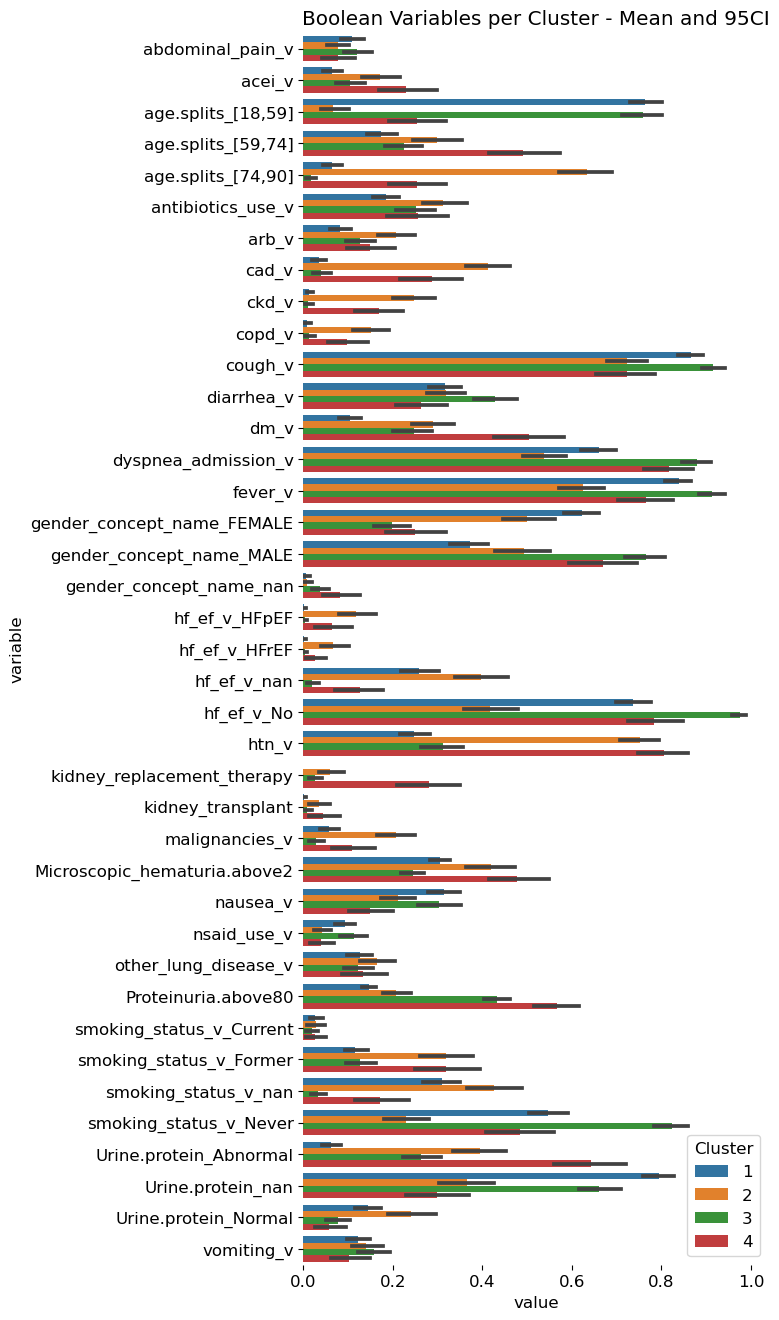

In [48]:
_melted_bool = X_fin_melted[X_fin_melted["variable"].isin(_boolean)].sort_values("variable", key=lambda x: x.str.lower())

fig, ax = plt.subplots(figsize=(6,16))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.barplot(x="value", y="variable", hue="cluster",
              data=_melted_bool, dodge=True,
              estimator=np.mean,
              #dodge=.8 - .8 / 3,
              #join=False, palette="dark",
              #markers="o", scale=.75, ci=None
              
            )
ax.set_title("Boolean Variables per Cluster - Mean and 95CI")
ax.legend(title="Cluster", loc="lower right")
#fig.savefig("../thesis/figures/impl/clustering/boolean_per_cluster.png", dpi=180)

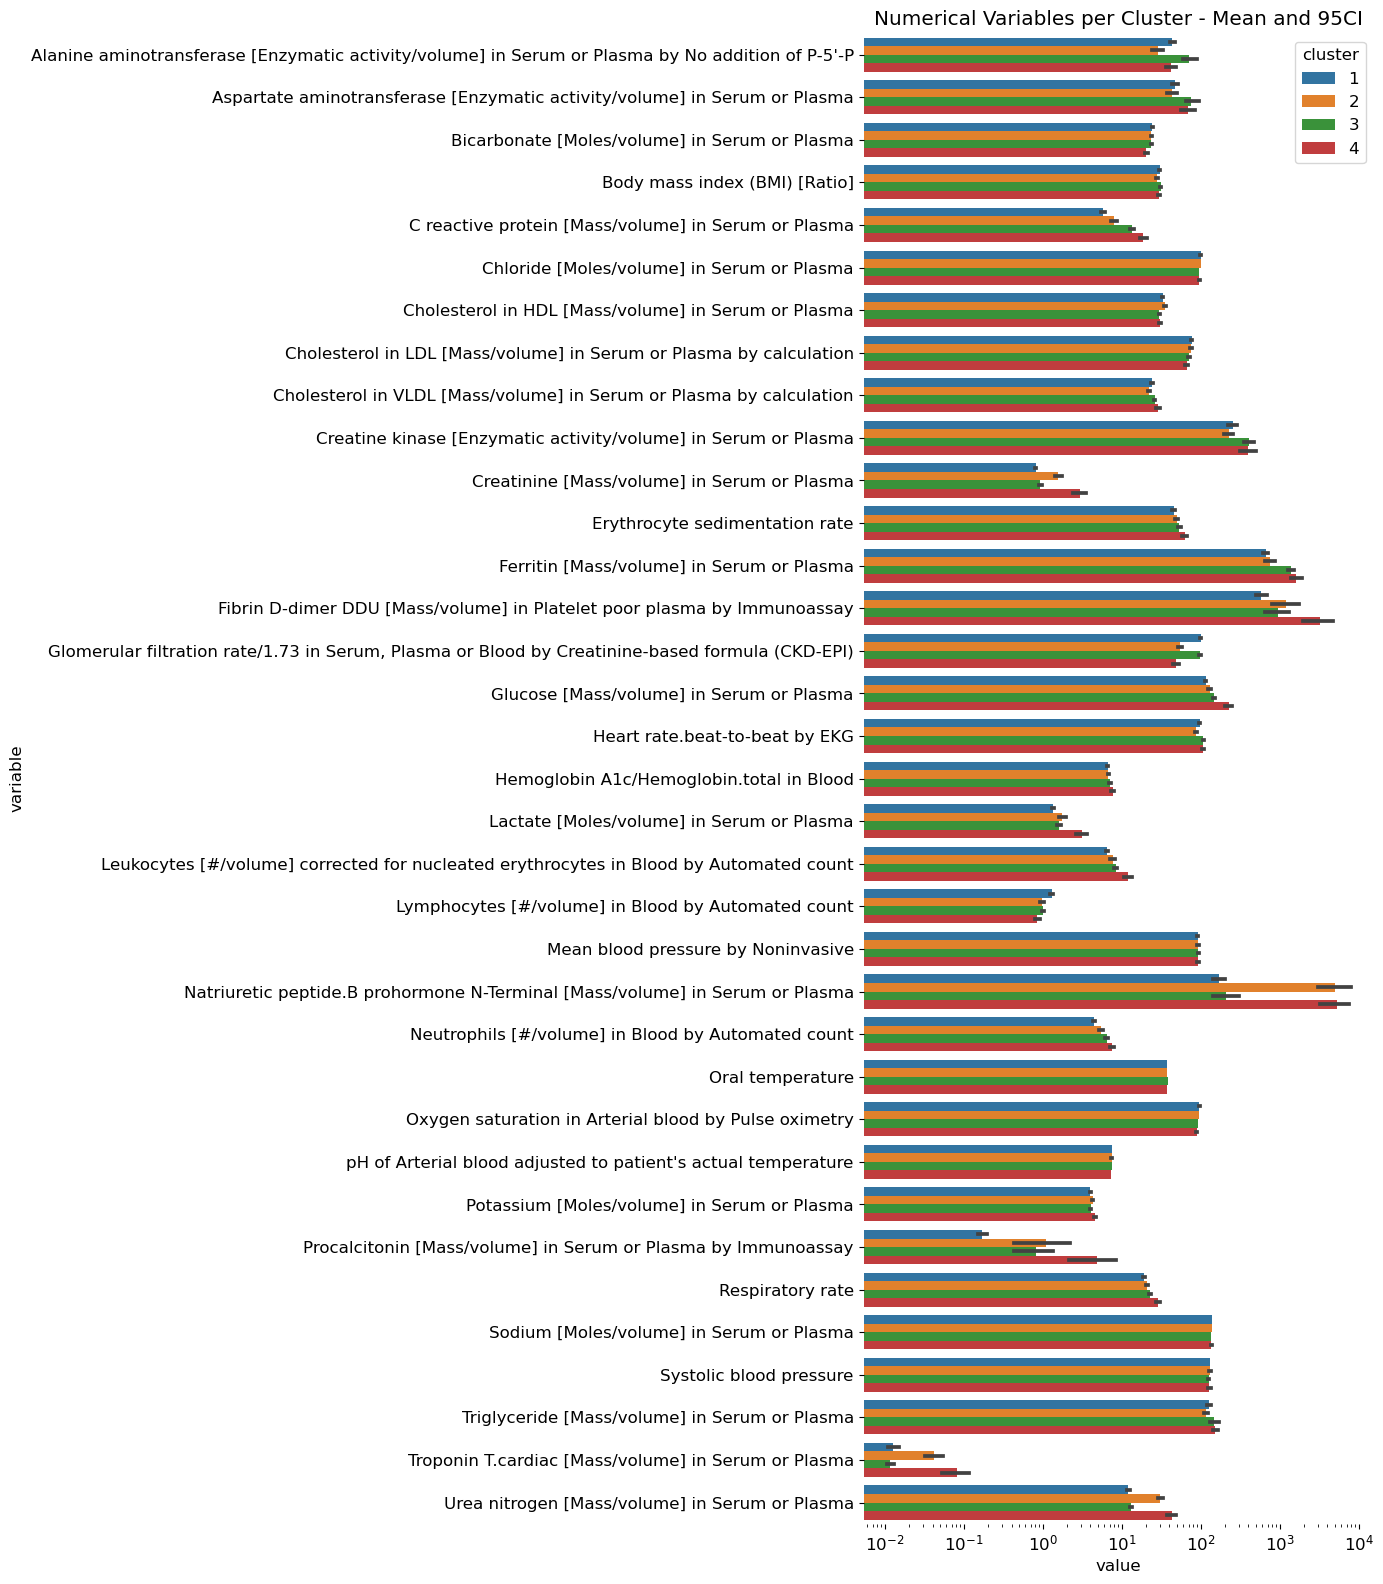

In [49]:
_melted_num = X_fin_melted[~X_fin_melted["variable"].isin(_boolean)].sort_values(by="variable", key=lambda x: x.str.lower())
_melted_num = _melted_num.replace({
    "Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)":
    "Glomerular filtration rate/1.73 in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)"
    })

fig, ax = plt.subplots(figsize=(14,16))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.barplot(x="value", y="variable", hue="cluster",
              data=_melted_num, dodge=True,
              estimator=np.mean,
              #dodge=.8 - .8 / 3,
              #join=False, palette="dark",
              #markers="o", scale=.75, ci=None
            )
ax.set_xscale("log")
ax.set_title("Numerical Variables per Cluster - Mean and 95CI")
#ax.legend(title="Cluster", loc="lower right")
fig.tight_layout()
#fig.savefig("../thesis/figures/impl/clustering/numeric_per_cluster.png", dpi=180)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


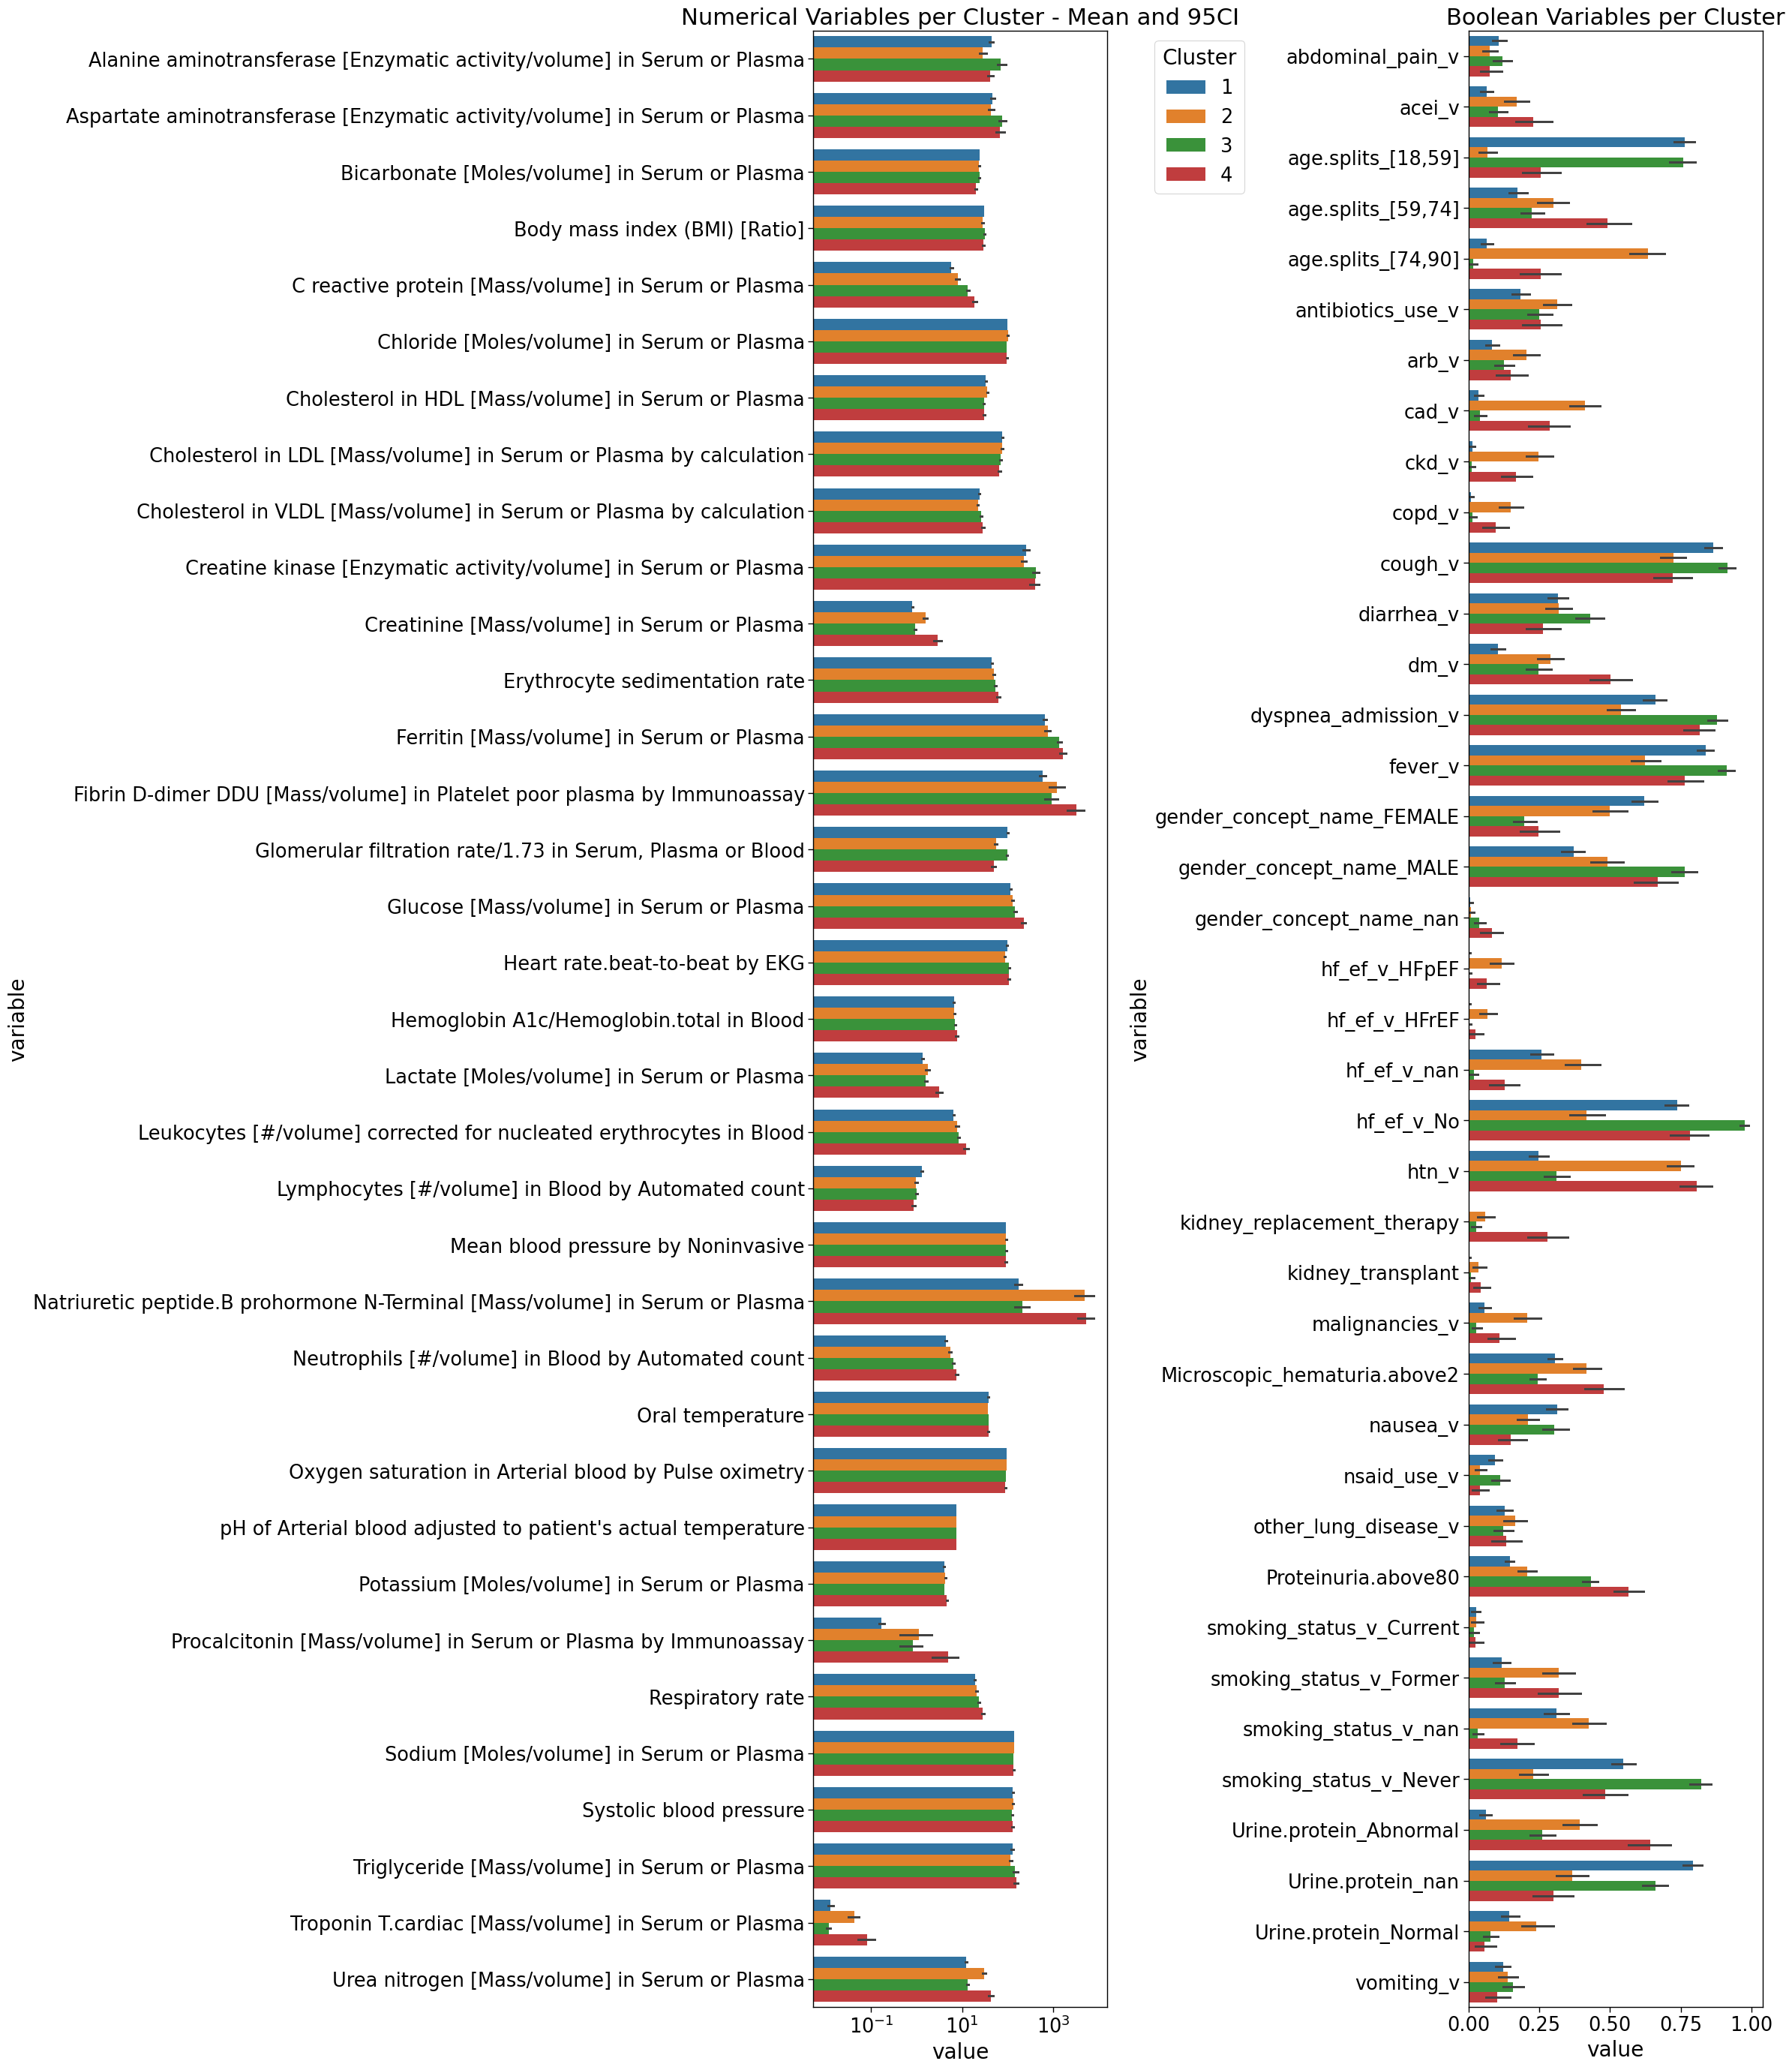

In [50]:
_melted_bool = X_fin_melted[X_fin_melted["variable"].isin(_boolean)].sort_values("variable", key=lambda x: x.str.lower())
_melted_num = X_fin_melted[~X_fin_melted["variable"].isin(_boolean)].sort_values(by="variable", key=lambda x: x.str.lower())
_melted_num = _melted_num.replace({
    "Glomerular filtration rate/1.73 sq M.predicted [Volume Rate/Area] in Serum, Plasma or Blood by Creatinine-based formula (CKD-EPI)":
    "Glomerular filtration rate/1.73 in Serum, Plasma or Blood",
    "Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P":
    "Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma",
    'Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count':
     'Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood',
    })

sns.set_context("paper", font_scale=2.1, #rc={"lines.linewidth": 2.5, "lines.markersize" : 2.5}
    )

fig, ax = plt.subplots(1, 2, figsize=(24,28))
#sns.despine(#bottom=True, #left=True)

#ax.legend(title="Cluster", loc="lower right")

sns.barplot(x="value", y="variable", hue="cluster",
              data=_melted_num, dodge=True,
              estimator=np.mean,
              ax=ax[0]
              #dodge=.8 - .8 / 3,
              #join=False, palette="dark",
              #markers="o", scale=.75, ci=None
            )
ax[0].set_xscale("log")
ax[0].set_title("Numerical Variables per Cluster - Mean and 95CI", size=22)

# Show each observation with a scatterplot
sns.barplot(x="value", y="variable", hue="cluster",
              data=_melted_bool, dodge=True,
              estimator=np.mean,
              ax=ax[1], #legend=False,
              #dodge=.8 - .8 / 3,
              #join=False, palette="dark",
              #markers="o", scale=.75, ci=None
              
            )
ax[1].set_title("Boolean Variables per Cluster", size=22)
#ax[1].legend(title="Cluster", loc="lower right")
ax[1].get_legend().remove()

fig.tight_layout()
ax[0].legend(title="Cluster", loc="upper right", bbox_to_anchor=(1.5, 1.0))
#fig.savefig("../thesis/figures/impl/clustering/bool_and_num_per_cluster_160dpi.png", dpi=160)
#fig.savefig("../thesis/figures/impl/clustering/bool_and_num_per_cluster_320dpi.png", dpi=320)

### Test significances

In [80]:
import scipy

col = "Oral temperature"
# Example of the Kruskal-Wallis H Test
data1 = X_fin[X_fin["cluster"] == 1][col]
data2 = X_fin[X_fin["cluster"] == 2][col]
data3 = X_fin[X_fin["cluster"] == 3][col]
data4 = X_fin[X_fin["cluster"] == 4][col]
stat, p = scipy.stats.kruskal(data1, data2, data3, data4)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=197.690, p=0.000
Probably different distributions


In [81]:
X_clusters = X_fin.groupby("cluster").median().round(3)

ps = []

for col in X.columns:
    data1 = X_fin[X_fin["cluster"] == 1][col]
    data2 = X_fin[X_fin["cluster"] == 2][col]
    data3 = X_fin[X_fin["cluster"] == 3][col]
    data4 = X_fin[X_fin["cluster"] == 4][col]
    stat, p = scipy.stats.kruskal(data1, data2, data3, data4)
    ps.append(p)
p_dict = dict(zip(X_fin.columns, ps))

In [82]:
ps_df = pd.DataFrame()
ps_df["Variable"] = p_dict.keys()
ps_df["p-value"] = p_dict.values()
ps_df.round(3).sort_values(by="p-value", ascending=False)[:10]

Variable  p-value
70            smoking_status_v_Current    0.859
27  Mean blood pressure by Noninvasive    0.420
18                    abdominal_pain_v    0.087
17                          diarrhea_v    0.011
16                          vomiting_v    0.007
8                 other_lung_disease_v    0.006
26             Systolic blood pressure    0.004
12                         nsaid_use_v    0.003
0           kidney_replacement_therapy    0.000
51      Erythrocyte sedimentation rate    0.000

In [83]:
import itertools
combis = []
for v in itertools.combinations([1, 2, 3, 4], 2):
    combis.append(v)

mwu_df = pd.DataFrame()

for col in X.columns:
    for cluster1, cluster2 in combis:
        d1 = X_fin[X_fin["cluster"] == cluster1][col]
        d2 = X_fin[X_fin["cluster"] == cluster2][col]
        stat, p = scipy.stats.mannwhitneyu(d1, d2)
        _d = {"Variable": [col], "cluster1": [cluster1],
                "cluster2": [cluster2], "p-value": [p] }
        mwu_df = pd.concat([mwu_df, pd.DataFrame.from_dict(_d)])
mwu_df[mwu_df["p-value"]>0.05]


Variable  cluster1  cluster2   p-value
0          kidney_transplant         1         3  0.204189
0          kidney_transplant         2         4  0.642456
0                      htn_v         1         3  0.690317
0                      cad_v         1         3  0.585539
0                     copd_v         1         3  0.892937
..                       ...       ...       ...       ...
0   smoking_status_v_Current         2         4  0.900249
0   smoking_status_v_Current         3         4  0.606716
0    smoking_status_v_Former         1         3  0.633427
0    smoking_status_v_Former         2         4  0.993241
0     smoking_status_v_Never         1         4  0.169955

[89 rows x 4 columns]

In [84]:
foo = pd.get_dummies(mwu_df["cluster1"])
foo.columns = pd.MultiIndex.from_product([["Cluster A"], foo.columns])
foo

foo2 = pd.get_dummies(mwu_df["cluster2"])
foo2.columns = pd.MultiIndex.from_product([["Cluster B"], foo2.columns])

mwu_new = pd.concat([foo, foo2], axis=1)
mwu_new["Variable"] = mwu_df["Variable"]
mwu_new["p-value"] = mwu_df["p-value"]

pretty_tab = mwu_new[mwu_new["p-value"] > 0.05][["Variable", "Cluster A", "Cluster B", "p-value"]].replace({1:"x", 0:""}).round(3)
print(mwu_new.shape, pretty_tab.shape)

(444, 8) (89, 8)


In [85]:
74*6 - pretty_tab.shape[0]

355

In [86]:
pretty_tab

Variable Cluster A       Cluster B       p-value
                                     1  2  3         2  3  4        
0          kidney_transplant         x                  x      0.204
0          kidney_transplant            x                  x   0.642
0                      htn_v         x                  x      0.690
0                      cad_v         x                  x      0.586
0                     copd_v         x                  x      0.893
..                       ...       ... .. ..       ... .. ..     ...
0   smoking_status_v_Current            x                  x   0.900
0   smoking_status_v_Current               x               x   0.607
0    smoking_status_v_Former         x                  x      0.633
0    smoking_status_v_Former            x                  x   0.993
0     smoking_status_v_Never         x                     x   0.170

[89 rows x 8 columns]

In [129]:
pretty_tab[pretty_tab["Variable"] == "Body mass index (BMI) [Ratio]"]

Variable Cluster A     Cluster B      p-value
                                         1 2 3         2  3 4        
0  Body mass index (BMI) [Ratio]         x                x     0.331

In [175]:
pretty_tab[(pretty_tab["Cluster B"][4] == "x")]

Variable Cluster A        \
                                                             1  2  3   
0                                  kidney_transplant            x      
0                               other_lung_disease_v         x         
0                               other_lung_disease_v            x      
0                               other_lung_disease_v               x   
0                                             acei_v            x      
0                                              arb_v         x         
0                                              arb_v               x   
0                                  antibiotics_use_v         x         
0                                  antibiotics_use_v               x   
0                                        nsaid_use_v            x      
0                                            cough_v            x      
0                                         vomiting_v         x         
0                                         vomiting_v               x   
0                                         diarrhea_v         x         
0                                   abdominal_pain_v         x         
0                                   abdominal_pain_v            x      
0                                   abdominal_pain_v               x   
0                       Microscopic_hematuria.above2            x      
0                                   Oral temperature         x         
0                     Heart rate.beat-to-beat by EKG               x   
0                            Systolic blood pressure         x         
0                            Systolic blood pressure            x      
0                            Systolic blood pressure               x   
0                 Mean blood pressure by Noninvasive         x         
0                 Mean blood pressure by Noninvasive            x      
0                 Mean blood pressure by Noninvasive               x   
0           Sodium [Moles/volume] in Serum or Plasma               x   
0  Alanine aminotransferase [Enzymatic activity/v...         x         
0  Creatine kinase [Enzymatic activity/volume] in...               x   
0  Natriuretic peptide.B prohormone N-Terminal [M...            x      
0          Ferritin [Mass/volume] in Serum or Plasma               x   
0         Chloride [Moles/volume] in Serum or Plasma               x   
0  Cholesterol in VLDL [Mass/volume] in Serum or ...               x   
0      Triglyceride [Mass/volume] in Serum or Plasma               x   
0  Cholesterol in HDL [Mass/volume] in Serum or P...               x   
0                         gender_concept_name_FEMALE               x   
0                               Urine.protein_Normal               x   
0                                  Urine.protein_nan            x      
0                                      hf_ef_v_HFpEF            x      
0                                      hf_ef_v_HFrEF            x      
0                                         hf_ef_v_No         x         
0                           smoking_status_v_Current         x         
0                           smoking_status_v_Current            x      
0                           smoking_status_v_Current               x   
0                            smoking_status_v_Former            x      
0                             smoking_status_v_Never         x         

  Cluster B      p-value  
          2 3  4          
0              x   0.642  
0              x   0.109  
0              x   0.318  
0              x   0.738  
0              x   0.834  
0              x   0.095  
0              x   0.135  
0              x   0.233  
0              x   0.344  
0              x   0.159  
0              x   0.126  
0              x   0.383  
0              x   0.845  
0              x   0.116  
0              x   0.181  
0              x   0.137  
0              x   0.831  
0              x   0.189  
0              x   0.596  
0              x   0

In [177]:
pretty_tab[(pretty_tab["Cluster A"][3] == "x") & (pretty_tab["Cluster B"][4] == "x")]

Variable Cluster A      Cluster B  \
                                                             1 2  3         2   
0                               other_lung_disease_v              x             
0                                              arb_v              x             
0                                  antibiotics_use_v              x             
0                                         vomiting_v              x             
0                                   abdominal_pain_v              x             
0                     Heart rate.beat-to-beat by EKG              x             
0                            Systolic blood pressure              x             
0                 Mean blood pressure by Noninvasive              x             
0           Sodium [Moles/volume] in Serum or Plasma              x             
0  Creatine kinase [Enzymatic activity/volume] in...              x             
0          Ferritin [Mass/volume] in Serum or Plasma              x             
0         Chloride [Moles/volume] in Serum or Plasma              x             
0  Cholesterol in VLDL [Mass/volume] in Serum or ...              x             
0      Triglyceride [Mass/volume] in Serum or Plasma              x             
0  Cholesterol in HDL [Mass/volume] in Serum or P...              x             
0                         gender_concept_name_FEMALE              x             
0                               Urine.protein_Normal              x             
0                           smoking_status_v_Current              x             

       p-value  
  3  4          
0    x   0.738  
0    x   0.135  
0    x   0.344  
0    x   0.845  
0    x   0.831  
0    x   0.129  
0    x   0.399  
0    x   0.273  
0    x   0.659  
0    x   0.564  
0    x   0.296  
0    x   0.123  
0    x   0.121  
0    x   0.172  
0    x   0.283  
0    x   0.199  
0    x   0.427  
0    x   0.607

In [125]:
medical_df["cluster"] = clusters
medical_df.groupby("cluster").median()["length_of_stay"]

cluster
1     2.0
2     7.0
3     9.0
4    11.0
Name: length_of_stay, dtype: float64

In [126]:
medical_df.groupby("cluster").quantile(0.75)["length_of_stay"] - medical_df.groupby("cluster").quantile(0.25)["length_of_stay"]

cluster
1     5.0
2     8.0
3    12.0
4    15.0
Name: length_of_stay, dtype: float64

In [134]:
medical_df["cluster"].value_counts()

1    490
3    378
2    254
4    157
Name: cluster, dtype: int64

In [131]:
X_fin.groupby("cluster").mean().filter(regex="BMI").round(1)

Body mass index (BMI) [Ratio]
cluster                               
1                                 30.2
2                                 28.1
3                                 31.0
4                                 29.4

In [132]:
X_fin.groupby("cluster").std().filter(regex="BMI").round(1)

Body mass index (BMI) [Ratio]
cluster                               
1                                  5.3
2                                  5.2
3                                  6.3
4                                  7.0

<AxesSubplot:xlabel='Body mass index (BMI) [Ratio]', ylabel='Density'>

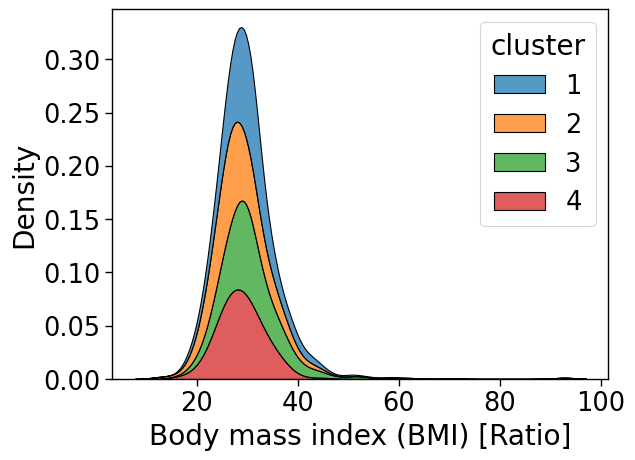

In [174]:

sns.kdeplot(data=X_fin, x="Body mass index (BMI) [Ratio]", hue="cluster", multiple="stack",
    palette=sns.color_palette()[:4], common_norm=False, common_grid=False)



#hue_order=range(0,k),
            #palette=sns.color_palette()[:k]) #palette=_cmap, #palette=cm.Dark2,

In [83]:
for _c in [1,2,3]:
    print(_c)
    print(pretty_tab[pretty_tab["Cluster A"][_c]=="x"]["Cluster B"].value_counts())

1
2  3  4
   x       21
      x    13
x          12
dtype: int64
2
2  3  4
      x    15
   x       10
dtype: int64
3
2  3  4
      x    18
dtype: int64


In [ ]:
fpath = "data/cluster_test.csv"
k = 4

pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=2)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=k, random_state=seed))
                 ])

if os.path.exists(fpath):
    print("Found file... loading from file.")
    X = pd.read_csv(fpath)
else:
    print("creating new clustered data...")
    Xs = pipe.fit_transform(X)
    clusters = KMeans(init="k-means++", n_clusters=k, random_state=seed).fit_predict(Xs)
    clusters = clusters+1 # increment by one for readability and everything later on...

    X["cluster"] = clusters
    X.to_csv(fpath, ignore_index=True)

## Finalise

From above we choose k-means with t-sne and complexity 10 and 4 clusters...

In [ ]:
fpath = "data/clustered_tsne.csv"
perp = 10
k = 4

pipe = Pipeline([('scaler', StandardScaler()),
                 ('tsne', TSNE(n_components=2, perplexity=perp,
                  learning_rate="auto", init="pca", random_state=seed)),
                 #('kmeans', KMeans(init="k-means++", n_clusters=n_clusters))
                 ])

if os.path.exists(fpath):
    print("Found file... loading from file.")
    X = pd.read_csv(fpath)
else:
    print("creating new clustered data...")
    Xs = pipe.fit_transform(X)
    clusters = KMeans(init="k-means++", n_clusters=k, random_state=seed).fit_predict(Xs)
    clusters = clusters+1 # increment by one for readability and everything later on...

    X["cluster"] = clusters
    X.to_csv(fpath, ignore_index=True)

Found file... loading from file.


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

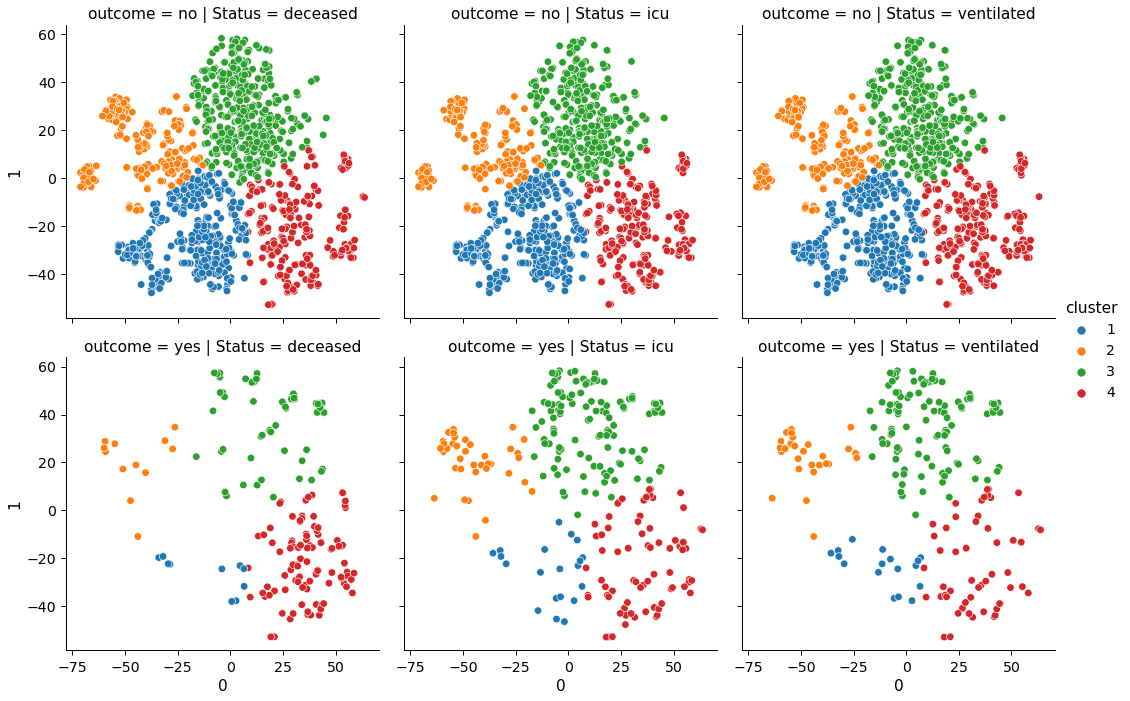

In [ ]:
"""fig, ax = plt.subplots(1,3, figsize=(32,7))

for i, t in enumerate(targets):
    sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], s=90,
            hue=clusters, palette=sns.color_palette()[:k], hue_order=range(0,k),
            ax=ax[i], style=df_targets[t], legend=False, markers=["o", "X"])
    ax[i].set_title(t)
fig.tight_layout()
"""

_pdf = pd.concat([pd.DataFrame(Xs), df_targets, pd.DataFrame(clusters, columns=["cluster"])], axis=1)

_pdfs = []
for i, t in enumerate(targets):
    #print(i,t)
    __pdf = _pdf[[0,1,t,"cluster"]]
    if i == 0: 
        __pdf["Status"] = "deceased"
        __pdf["outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    elif i == 1:
        __pdf["Status"] = "icu"
        __pdf["outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    elif i == 2:
        __pdf["Status"] = "ventilated"
        __pdf["outcome"] = __pdf[t]
        __pdf.drop(t, inplace=True, axis=1)
    _pdfs.append(__pdf)

_ppdf = pd.concat(_pdfs)
_ppdf["outcome"].replace({0:"no", 1:"yes"}, inplace=True)

p = sns.relplot(data=_ppdf, x=0, y=1, col="Status", row="outcome",
 hue="cluster", 
 palette=sns.color_palette()[:k], hue_order=range(1,k+1)
 )
#p.savefig("../thesis/figures/impl/clustering/tsne_clustered.png")

In [ ]:
#print( ((pd.concat([X["cluster"], df_targets], axis=1).groupby("cluster").sum() / pd.concat([X["cluster"], df_targets], axis=1).groupby("cluster").count()).round(3)*100).to_latex() )

((pd.concat([X["cluster"], df_targets], axis=1).groupby("cluster").sum() / pd.concat([X["cluster"], df_targets], axis=1).groupby("cluster").count()).round(3)*100)


last.status  is_icu  was_ventilated
cluster                                     
1                2.9     5.8             4.9
2                5.9    18.6            13.2
3               13.0    28.5            26.4
4               32.4    25.7            18.6

In [ ]:
interesting_columns = ["age", "smoking", "BMI", "gender",
    # outpatient: Outpatient care describes any medical procedure or treatment that does not
    #  require a patient to stay overnight. When considering inpatient vs. outpatient care,
    #  whether or not the patient has an overnight stay is what typically defines the difference
    #  between the two, but exceptions exist. For example, an emergency room (ER) visit is generally
    #  considered an outpatient service, even if a patient will likely require an overnight stay.
    #  If an ER visit results in an extended stay and a doctor formally admits the patient to the 
    #  hospital, that patient’s status changes to inpatient.
    # inpatient: Inpatient care describes treatments and procedures that require observation
    #  of the patient by physicians, clinicians, or other medical professionals over a number of days.
    "visit_concept", 
    #"[kK]idney", # acute kidney injury
    "replace", "transplant", 
    #"use",
    "malignancies",  # cancer 
    "nsaid" # painkillers Nonsteroidal anti-inflammatory drugs
 ]
fstring = ""
for f in interesting_columns:
    fstring += f"({f})|"
fstring = fstring[:-1] # remove last pipe
X.groupby("cluster").mean().round(4).filter(regex=fstring) # |(fever) 

kidney_replacement_therapy  kidney_transplant  malignancies_v  \
cluster                                                                  
1                            0.0029             0.0029          0.0697   
2                            0.0098             0.0000          0.0363   
3                            0.0532             0.0000          0.0602   
4                            0.1453             0.0642          0.1459   

         nsaid_use_v  BMI.over30  BMI.over35  \
cluster                                        
1             0.0715      0.3458      0.1228   
2             0.0961      0.4892      0.2618   
3             0.1130      0.3944      0.1977   
4             0.0486      0.3459      0.1115   

         39156-5_Body mass index (BMI) [Ratio]  age.splits_[18,59]  \
cluster                                                              
1                                      28.8229              0.7147   
2                                      31.2155              0.7647   
3                                      29.9562              0.6111   
4                                      28.1261              0.1689   

         age.splits_[59,74]  age.splits_[74,90]  \
cluster                                           
1                    0.1758              0.1095   
2                    0.1912              0.0441   
3                    0.3148              0.0741   
4                    0.2939              0.5372   

         visit_concept_name_Emergency Room Visit  \
cluster                                            
1                                         0.6801   
2                                         0.3431   
3                                         0.0278   
4                                         0.0304   

         visit_concept_name_Inpatient Visit  \
cluster                                       
1                                    0.3141   
2                                    0.6569   
3                                    0.9722   
4                                    0.9696   

         visit_concept_name_Outpatient Visit  gender_concept_name_FEMALE  \
cluster                                                                    
1                                     0.0058                      0.4726   
2                                     0.0000                      0.5245   
3                                     0.0000                      0.3588   
4                                     0.0000                      0.4054   

         gender_concept_name_MALE  gender_concept_name_nan  \
cluster                                                      
1                          0.5187                   0.0086   
2                          0.4461                   0.0294   
3                          0.6019                   0.0394   
4                          0.5743                   0.0203   

         smoking_status_v_Current  smoking_status_v_Former  \
cluster                                                      
1                          0.0519                   0.0951   
2                          0.0000                   0.1127   
3                          0.0139                   0.1968   
4                          0.0236                   0.3209   

         smoking_status_v_Never  smoking_status_v_nan  
cluster                                                
1                        0.3401                0.5130  
2                        0.7892                0.0980  
3                        0.7569                0.0324  
4                        0.3615                0.2939

### Feature Importances

Lets determine important features for the targets outcome by training a dumb D-Tree classifier and check the importances

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def dtree_variables_check(df, target:str):
    x = df.copy()
    x = x.drop("cluster", axis=1)
    clf = DecisionTreeClassifier(random_state=seed).fit(x, df_targets[target])
    print("For target {} train score of dtree was: {} ".format(target, clf.score(x, df_targets[target])))

    importances = clf.feature_importances_
    imp_df = pd.DataFrame(importances, index=x.columns, columns=[f"imp-{target}"]).sort_values(by=f"imp-{target}", ascending=False)[:50]
    return imp_df

In [ ]:
_df1 = dtree_variables_check(X, "last.status")
_df2 = dtree_variables_check(X, "is_icu")
_df3 = dtree_variables_check(X, "was_ventilated")
_df = pd.concat([_df1, _df2, _df3], axis=1)
#_df.dropna(axis=0)

For target last.status train score of dtree was: 1.0 
For target is_icu train score of dtree was: 1.0 
For target was_ventilated train score of dtree was: 1.0 


In [ ]:
_df.sort_values(by="imp-last.status", ascending=False)[:50]

imp-last.status  \
Acute.Kidney.Injury..during.hospitalization.               0.289204   
age.splits_[18,59]                                         0.110404   
2524-7_Lactate [Moles/volume] in Serum or Plasma           0.050881   
gender_concept_name_nan                                    0.049456   
59408-5_Oxygen saturation in Arterial blood by ...         0.042790   
Troponin.above0.01                                         0.038290   
1920-8_Aspartate aminotransferase [Enzymatic ac...         0.035701   
731-0_Lymphocytes [#/volume] in Blood by Automa...         0.027053   
Proteinuria.above80                                        0.018983   
nsaid_use_v                                                0.018588   
4548-4_Hemoglobin A1c/Hemoglobin.total in Blood            0.018187   
1744-2_Alanine aminotransferase [Enzymatic acti...         0.018174   
48058-2_Fibrin D-dimer DDU [Mass/volume] in Pla...         0.017130   
33762-6_Natriuretic peptide.B prohormone N-Term...         0.016765   
1963-8_Bicarbonate [Moles/volume] in Serum or P...         0.013969   
1988-5_C reactive protein [Mass/volume] in Seru...         0.013165   
9279-1_Respiratory rate                                    0.013077   
smoking_status_v_nan                                       0.012946   
blood_pH.above7.45                                         0.012417   
Lymphocytes.under1k                                        0.012417   
2276-4_Ferritin [Mass/volume] in Serum or Plasma           0.012029   
2345-7_Glucose [Mass/volume] in Serum or Plasma            0.011443   
MAP.below65                                                0.010267   
fever_v                                                    0.009509   
2823-3_Potassium [Moles/volume] in Serum or Plasma         0.009424   
2157-6_Creatine kinase [Enzymatic activity/volu...         0.008594   
75241-0_Procalcitonin [Mass/volume] in Serum or...         0.008587   
days_prior_sx                                              0.008291   
2571-8_Triglyceride [Mass/volume] in Serum or P...         0.007805   
76536-2_Mean blood pressure by Noninvasive                 0.007692   
2085-9_Cholesterol in HDL [Mass/volume] in Seru...         0.006854   
76282-3_Heart rate.beat-to-beat by EKG                     0.006537   
33254-4_pH of Arterial blood adjusted to patien...         0.006278   
Urine.protein_nan                                          0.005821   
pulseOx.under90                                            0.005543   
vomiting_v                                                 0.005543   
dyspnea_admission_v                                        0.004435   
antibiotics_use_v                                          0.004435   
D_dimer.below500                                           0.003326   
Sodium.between135and145                                    0.003326   
arb_v                                                      0.003326   
2951-2_Sodium [Moles/volume] in Serum or Plasma            0.003326   
Chloride.above107                                          0.003326   
2160-0_Creatinine [Mass/volume] in Serum or Plasma         0.003326   
33256-9_Leukocytes [#/volume] corrected for nuc...         0.003287   
30341-2_Erythrocyte sedimentation rate                     0.003198   
3094-0_Urea nitrogen [Mass/volume] in Serum or ...         0.003049   
8331-1_Oral temperature                                    0.001556   
62238-1_Glomerular filtration rate/1.73 sq M.pr...         0.000269   
39156-5_Body mass index (BMI) [Ratio]                      0.000000   

                                                    imp-is_icu  \
Acute.Kidney.Injury..during.hospitalization.          0.013256   
age.splits_[18,59]                                         NaN   
2524-7_Lactate [Moles/volume] in Serum or Plasma      0.031341   
gender_concept_name_nan                               0.004422   
59408-5_Oxygen saturation in Arterial blood by ...    0.032367   
Troponin.above0.01                